## Requirements

- python 3.8+

If using pip instead of uv, install the requirements using:

```bash
pip install numpy matplotlib scikit-learn
```

or convert `pyproject.toml` to requirements and run:

```bash
pip install -r requirements.txt
```

In [2]:
# !uv init
# !uv add numpy
# !uv add matplotlib
# !uv add scikit-learn
# !uv add pandas
# !uv add seaborn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
import os
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
warnings.filterwarnings('ignore')


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
os.makedirs('out', exist_ok=True)

## Background reading

Quick overview from scikit learn:
![sphx_glr_plot_cluster_comparison_001.png](sphx_glr_plot_cluster_comparison_001.png)

<table class="table">
<colgroup>
<col style="width: 15.1%">
<col style="width: 16.1%">
<col style="width: 20.4%">
<col style="width: 26.9%">
<col style="width: 21.5%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Method name</p></th>
<th class="head"><p>Parameters</p></th>
<th class="head"><p>Scalability</p></th>
<th class="head"><p>Usecase</p></th>
<th class="head"><p>Geometry (metric used)</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><a class="reference internal" href="#k-means"><span class="std std-ref">K-Means</span></a></p></td>
<td><p>number of clusters</p></td>
<td><p>Very large <code class="docutils literal notranslate"><span class="pre">n_samples</span></code>, medium <code class="docutils literal notranslate"><span class="pre">n_clusters</span></code> with
<a class="reference internal" href="#mini-batch-kmeans"><span class="std std-ref">MiniBatch code</span></a></p></td>
<td><p>General-purpose, even cluster size, flat geometry,
not too many clusters, inductive</p></td>
<td><p>Distances between points</p></td>
</tr>
<tr class="row-odd"><td><p><a class="reference internal" href="#affinity-propagation"><span class="std std-ref">Affinity propagation</span></a></p></td>
<td><p>damping, sample preference</p></td>
<td><p>Not scalable with n_samples</p></td>
<td><p>Many clusters, uneven cluster size, non-flat geometry, inductive</p></td>
<td><p>Graph distance (e.g. nearest-neighbor graph)</p></td>
</tr>
<tr class="row-even"><td><p><a class="reference internal" href="#mean-shift"><span class="std std-ref">Mean-shift</span></a></p></td>
<td><p>bandwidth</p></td>
<td><p>Not scalable with <code class="docutils literal notranslate"><span class="pre">n_samples</span></code></p></td>
<td><p>Many clusters, uneven cluster size, non-flat geometry, inductive</p></td>
<td><p>Distances between points</p></td>
</tr>
<tr class="row-odd"><td><p><a class="reference internal" href="#spectral-clustering"><span class="std std-ref">Spectral clustering</span></a></p></td>
<td><p>number of clusters</p></td>
<td><p>Medium <code class="docutils literal notranslate"><span class="pre">n_samples</span></code>, small <code class="docutils literal notranslate"><span class="pre">n_clusters</span></code></p></td>
<td><p>Few clusters, even cluster size, non-flat geometry, transductive</p></td>
<td><p>Graph distance (e.g. nearest-neighbor graph)</p></td>
</tr>
<tr class="row-even"><td><p><a class="reference internal" href="#hierarchical-clustering"><span class="std std-ref">Ward hierarchical clustering</span></a></p></td>
<td><p>number of clusters or distance threshold</p></td>
<td><p>Large <code class="docutils literal notranslate"><span class="pre">n_samples</span></code> and <code class="docutils literal notranslate"><span class="pre">n_clusters</span></code></p></td>
<td><p>Many clusters, possibly connectivity constraints, transductive</p></td>
<td><p>Distances between points</p></td>
</tr>
<tr class="row-odd"><td><p><a class="reference internal" href="#hierarchical-clustering"><span class="std std-ref">Agglomerative clustering</span></a></p></td>
<td><p>number of clusters or distance threshold, linkage type, distance</p></td>
<td><p>Large <code class="docutils literal notranslate"><span class="pre">n_samples</span></code> and <code class="docutils literal notranslate"><span class="pre">n_clusters</span></code></p></td>
<td><p>Many clusters, possibly connectivity constraints, non Euclidean
distances, transductive</p></td>
<td><p>Any pairwise distance</p></td>
</tr>
<tr class="row-even"><td><p><a class="reference internal" href="#dbscan"><span class="std std-ref">DBSCAN</span></a></p></td>
<td><p>neighborhood size</p></td>
<td><p>Very large <code class="docutils literal notranslate"><span class="pre">n_samples</span></code>, medium <code class="docutils literal notranslate"><span class="pre">n_clusters</span></code></p></td>
<td><p>Non-flat geometry, uneven cluster sizes, outlier removal,
transductive</p></td>
<td><p>Distances between nearest points</p></td>
</tr>
<tr class="row-odd"><td><p><a class="reference internal" href="#hdbscan"><span class="std std-ref">HDBSCAN</span></a></p></td>
<td><p>minimum cluster membership, minimum point neighbors</p></td>
<td><p>large <code class="docutils literal notranslate"><span class="pre">n_samples</span></code>, medium <code class="docutils literal notranslate"><span class="pre">n_clusters</span></code></p></td>
<td><p>Non-flat geometry, uneven cluster sizes, outlier removal,
transductive, hierarchical, variable cluster density</p></td>
<td><p>Distances between nearest points</p></td>
</tr>
<tr class="row-even"><td><p><a class="reference internal" href="#optics"><span class="std std-ref">OPTICS</span></a></p></td>
<td><p>minimum cluster membership</p></td>
<td><p>Very large <code class="docutils literal notranslate"><span class="pre">n_samples</span></code>, large <code class="docutils literal notranslate"><span class="pre">n_clusters</span></code></p></td>
<td><p>Non-flat geometry, uneven cluster sizes, variable cluster density,
outlier removal, transductive</p></td>
<td><p>Distances between points</p></td>
</tr>
<tr class="row-odd"><td><p><a class="reference internal" href="mixture.html#mixture"><span class="std std-ref">Gaussian mixtures</span></a></p></td>
<td><p>many</p></td>
<td><p>Not scalable</p></td>
<td><p>Flat geometry, good for density estimation, inductive</p></td>
<td><p>Mahalanobis distances to  centers</p></td>
</tr>
<tr class="row-even"><td><p><a class="reference internal" href="#birch"><span class="std std-ref">BIRCH</span></a></p></td>
<td><p>branching factor, threshold, optional global clusterer.</p></td>
<td><p>Large <code class="docutils literal notranslate"><span class="pre">n_clusters</span></code> and <code class="docutils literal notranslate"><span class="pre">n_samples</span></code></p></td>
<td><p>Large dataset, outlier removal, data reduction, inductive</p></td>
<td><p>Euclidean distance between points</p></td>
</tr>
<tr class="row-odd"><td><p><a class="reference internal" href="#bisect-k-means"><span class="std std-ref">Bisecting K-Means</span></a></p></td>
<td><p>number of clusters</p></td>
<td><p>Very large <code class="docutils literal notranslate"><span class="pre">n_samples</span></code>, medium <code class="docutils literal notranslate"><span class="pre">n_clusters</span></code></p></td>
<td><p>General-purpose, even cluster size, flat geometry,
no empty clusters, inductive, hierarchical</p></td>
<td><p>Distances between points</p></td>
</tr>
</tbody>
</table>

### K-means

Optimization criterion (inertia):

$$ \sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2) $$

Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.
But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as Principal component analysis (PCA) prior to k-means clustering can alleviate this problem and speed up the computations.

Using scikit kmeans (Lloyd):
- n_clusters, k
- n_init, initialization method
- max_iter, i
- O(nkdi), linear in practice
- sensitive to initialization and may converge to local optima
- assumes clusters are isotropic and have similar variance
- requires the number of clusters (K) to be specified beforehand

### DBScan

Using scikit dbscan:
- eps, epsilon,
- min_samples: minPoints
- O(n^2)
- struggles with datasets of varying densities
- not suitable for high-dimensional data

## Setup dataset, kmeans, dbscan, control

In [3]:
def run_kmeans(X, n_clusters=3):
    """Run K-Means clustering"""
    start_time = time.time()
    
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=RANDOM_SEED)
    labels = kmeans.fit_predict(X)
    
    runtime = time.time() - start_time
    return labels, kmeans, runtime

def run_dbscan(X, eps=0.3, min_samples=5):
    """Run DBSCAN clustering"""
    start_time = time.time()
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    labels = dbscan.fit_predict(X)
    
    runtime = time.time() - start_time
    return labels, dbscan, runtime


def evaluate_clustering(X, labels, algorithm_name):
    """Calculate clustering quality metrics"""
    
    # Count clusters (excluding noise points labeled -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    print(f"{algorithm_name} Results:")
    print(f"Number of clusters: {n_clusters}")
    print(f"Noise points: {n_noise}")
    
    # Calculate metrics only if we have more than 1 cluster
    if n_clusters > 1 and n_clusters < len(X):
        # Filter out noise points for metric calculation
        mask = labels != -1
        if mask.sum() > 0:
            try:
                silhouette = silhouette_score(X[mask], labels[mask])
                davies_bouldin = davies_bouldin_score(X[mask], labels[mask])
                calinski = calinski_harabasz_score(X[mask], labels[mask])
                
                print(f"Silhouette Score: {silhouette:.3f} (higher is better)")
                print(f"Davies-Bouldin Index: {davies_bouldin:.3f} (lower is better)")
                print(f"Calinski-Harabasz Score: {calinski:.3f} (higher is better)")
                
                return {
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'silhouette': silhouette,
                    'davies_bouldin': davies_bouldin,
                    'calinski_harabasz': calinski
                }
            except:
                print("Could not calculate quality metrics")
    else:
        print("Not enough clusters for quality metrics")
    
    return None


def plot_comparison(X, y_true, labels_kmeans, labels_dbscan, dataset_name):
    """Utility fn for side-by-side comparison of K-Means and DBSCAN, only 2D or 3D supported"""

    n_features = X.shape[1]
    if n_features == 2:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # Ground truth
        axes[0].scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', s=30, alpha=0.7)
        axes[0].set_title(f'{dataset_name}: Ground Truth')
        axes[0].set_xlabel('Feature 1')
        axes[0].set_ylabel('Feature 2')
        
        # K-Means results
        axes[1].scatter(X[:, 0], X[:, 1], c=labels_kmeans, cmap='viridis', s=30, alpha=0.7)
        axes[1].set_title(f'{dataset_name}: K-Means')
        axes[1].set_xlabel('Feature 1')
        axes[1].set_ylabel('Feature 2')
        
        # DBSCAN results
        colors = labels_dbscan.copy()
        axes[2].scatter(X[:, 0], X[:, 1], c=colors, cmap='viridis', s=30, alpha=0.7)
        axes[2].set_title(f'{dataset_name}: DBSCAN')
        axes[2].set_xlabel('Feature 1')
        axes[2].set_ylabel('Feature 2')
        
        plt.tight_layout()
        plt.savefig(f'out/{n_features}d-{dataset_name}.png')
        plt.show()
    elif n_features == 3:
        fig = plt.figure(figsize=(18,6))
        
        # Ground truth
        ax1 = fig.add_subplot(131, projection='3d')
        ax1.scatter(X[:,0], X[:,1], X[:,2], c=y_true, cmap='viridis', s=30, alpha=0.7)
        ax1.set_title(f'{dataset_name}: Ground Truth')
        ax1.set_xlabel('Feature 1')
        ax1.set_ylabel('Feature 2')
        ax1.set_zlabel('Feature 3')
        
        # K-Means results
        ax2 = fig.add_subplot(132, projection='3d')
        ax2.scatter(X[:,0], X[:,1], X[:,2], c=labels_kmeans, cmap='viridis', s=30, alpha=0.7)
        ax2.set_title(f'{dataset_name}: K-Means')
        ax2.set_xlabel('Feature 1')
        ax2.set_ylabel('Feature 2')
        ax2.set_zlabel('Feature 3')
        
        # DBSCAN results
        ax3 = fig.add_subplot(133, projection='3d')
        colors = labels_dbscan.copy()
        ax3.scatter(X[:,0], X[:,1], X[:,2], c=colors, cmap='viridis', s=30, alpha=0.7)
        ax3.set_title(f'{dataset_name}: DBSCAN')
        ax3.set_xlabel('Feature 1')
        ax3.set_ylabel('Feature 2')
        ax3.set_zlabel('Feature 3')
        
        plt.tight_layout()
        plt.savefig(f'out/{n_features}d-{dataset_name}.png')
        plt.show()
    else:
        print("Only 2D and 3D supported, skipping...")

## Experiments

Generate datasets in 2D or 3D to explore the following cases:
- blobs (k-means advantage)
- moons (dbscan advantage)
- concentric circles (dbscan advantage)
- noisy blobs
- anisotropic blobs (k-means weakness)
- unequal variance (k-means weakness)
- uneven size blobs (k-means weakness)
- uneven density (dbscan weakness)
- higher dimensions (k-means scales linearly with dimensions but suffers from curse of dimensionality, dbscan too but spatial indexing like k-d trees degenerates at higher dimensions)

KMeans and MiniBatchKMeans suffer from the phenomenon called the Curse of Dimensionality for high dimensional datasets such as text data. That is the reason why the overall scores improve when using [LSA](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py). Using LSA reduced data also improves the stability and requires lower clustering time, though keep in mind that the LSA step itself takes a long time, especially with hashed vectors.

In [4]:
def generate_datasets(n_features=2):
    """
    Generate multiple synthetic datasets for clustering evaluation.
    
    Moons and circles are only 2D, so they are padded with zeros.
    Anisotropic blobs are hard-coded to stretch blobs using a 2D linear transformation, so they work only in 2D.
    """
    datasets = {}
    
    # Dataset 1: Spherical Blobs
    X1, y1 = make_blobs(n_samples=500, centers=4, n_features=n_features, 
                        cluster_std=0.8, random_state=RANDOM_SEED)
    datasets['blobs'] = (X1, y1)
    
    # Dataset 2: Moon Shapes in 2D, pad higher dimensions with zeros
    X2, y2 = make_moons(n_samples=400, noise=0.08, random_state=RANDOM_SEED)
    if n_features > 2:
        zeros_pad = np.zeros((X2.shape[0], n_features - 2))
        X2 = np.hstack([X2, zeros_pad])
    datasets['moons'] = (X2, y2)
    
    # Dataset 3: Concentric Circles in 2D, pad higher dimensions with zeros
    X3, y3 = make_circles(n_samples=400, noise=0.05, factor=0.5, random_state=RANDOM_SEED)
    if n_features > 2:
        zeros_pad = np.zeros((X3.shape[0], n_features - 2))
        X3 = np.hstack([X3, zeros_pad])
    datasets['circles'] = (X3, y3)
    
    # Dataset 4: Noisy Blobs (noise robustness)
    X4, y4 = make_blobs(n_samples=400, centers=3, n_features=n_features, 
                        cluster_std=0.6, random_state=RANDOM_SEED)
    n_outliers = int(0.15 * len(X4))
    outliers = np.random.uniform(low=X4.min(axis=0), high=X4.max(axis=0), 
                                size=(n_outliers, n_features))
    X4_noisy = np.vstack([X4, outliers])
    y4_noisy = np.hstack([y4, np.full(n_outliers, -1)])  # -1 for noise
    datasets['noisy_blobs'] = (X4_noisy, y4_noisy)
    
    # Dataset 5: Anisotropic blobs (stretch cluster using a 2D linear transformation, skip for other dims)
    X5, y5 = make_blobs(n_samples=500, centers=3, n_features=n_features, cluster_std=1.0, random_state=RANDOM_SEED)
    if n_features == 2:
        transformation = np.array([[0.6, -0.6], [-0.4, 0.8]])
        X5_aniso = np.dot(X5, transformation)
    else:
        X5_aniso = X5  # Skip
    datasets['anisotropic'] = (X5_aniso, y5)
    
    # Dataset 6: Unequal variances (non-spherical, different spread)
    if n_features == 2:
        cluster_stds = [0.2, 2.5, 0.5]
        X6, y6 = make_blobs(n_samples=500, centers=3, n_features=n_features,
                            cluster_std=cluster_stds, random_state=RANDOM_SEED)
        datasets['unequal_var'] = (X6, y6)
    else:
        # For higher D, just normal blobs
        X6, y6 = make_blobs(n_samples=500, centers=3, n_features=n_features,
                            cluster_std=1.0, random_state=RANDOM_SEED)
        datasets['unequal_var'] = (X6, y6)
    
    # Dataset 7: Varying densities - only 2D recommended
    if n_features == 2:
        X7a, y7a = make_blobs(n_samples=300, centers=[[-3, -3]], cluster_std=0.2, random_state=RANDOM_SEED)
        X7b, y7b = make_blobs(n_samples=600, centers=[[3, 3]], cluster_std=1.2, random_state=RANDOM_SEED+1)
        X7 = np.vstack([X7a, X7b])
        y7 = np.hstack([np.zeros(len(X7a)), np.ones(len(X7b))])
        datasets['varying_density'] = (X7, y7)
    
    # Dataset 8: Highly overlapping blobs
    X8, y8 = make_blobs(n_samples=500, centers=2, n_features=n_features, cluster_std=2.5, random_state=RANDOM_SEED)
    datasets['overlap'] = (X8, y8)
    
    # Dataset 9: Unevenly sized Gaussians
    X9a, y9a = make_blobs(n_samples=100, centers=[[-5]*n_features], cluster_std=0.2, random_state=RANDOM_SEED)
    X9b, y9b = make_blobs(n_samples=900, centers=[[5]*n_features], cluster_std=0.8, random_state=RANDOM_SEED+1)
    X9 = np.vstack([X9a, X9b])
    y9 = np.hstack([np.zeros(len(X9a)), np.ones(len(X9b))])
    datasets['uneven_blobs'] = (X9, y9)
    
    return datasets

## Sanity check

Play around with the weaknesses of kmeans:
- Non-optimal number of clusters: in a real setting there is no uniquely defined true number of clusters. An appropriate number of clusters has to be decided from data-based criteria and knowledge of the intended goal.
- Anisotropically distributed blobs: k-means consists of minimizing sample’s euclidean distances to the centroid of the cluster they are assigned to. As a consequence, k-means is more appropriate for clusters that are isotropic and normally distributed (i.e. spherical gaussians).
- Unequal variance: k-means is equivalent to taking the maximum likelihood estimator for a “mixture” of k gaussian distributions with the same variances but with possibly different means.
- Unevenly sized blobs: there is no theoretical result about k-means that states that it requires similar cluster sizes to perform well, yet minimizing euclidean distances does mean that the more sparse and high-dimensional the problem is, the higher is the need to run the algorithm with different centroid seeds to ensure a global minimal inertia.

Play around with the weaknesses of dbscan:
- Uneven variance
- Uneven density

> DBSCAN is memory inefficient.
> It constructs a full pairwise similarity matrix in the case where kd-trees or ball-trees cannot be used (e.g., with sparse matrices). This matrix will consume floats. A couple of mechanisms for getting around this are:
- Use OPTICS clustering in conjunction with the extract_dbscan method. OPTICS clustering also calculates the full pairwise matrix, but only keeps one row in memory at a time (memory complexity n).
- A sparse radius neighborhood graph (where missing entries are presumed to be out of eps) can be precomputed in a memory-efficient way and dbscan can be run over this with metric='precomputed'. See sklearn.neighbors.NearestNeighbors.radius_neighbors_graph.
- The dataset can be compressed, either by removing exact duplicates if these occur in your data, or by using BIRCH. Then you only have a relatively small number of representatives for a large number of points. You can then provide a sample_weight when fitting DBSCAN.


TESTING ON: BLOBS
Dataset size: 500 samples, 2 features
K-Means Runtime: 2.1918 seconds
K-Means Results:
Number of clusters: 4
Noise points: 0
Silhouette Score: 0.834 (higher is better)
Davies-Bouldin Index: 0.234 (lower is better)
Calinski-Harabasz Score: 8950.625 (higher is better)
DBSCAN Runtime: 0.0061 seconds
DBSCAN Results:
Number of clusters: 5
Noise points: 36
Silhouette Score: 0.716 (higher is better)
Davies-Bouldin Index: 0.403 (lower is better)
Calinski-Harabasz Score: 7826.867 (higher is better)


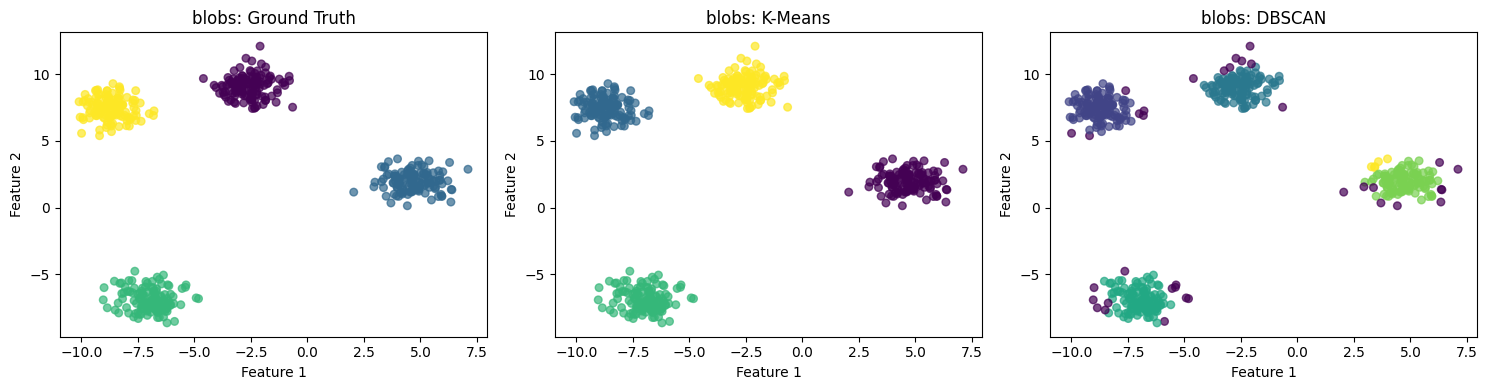

TESTING ON: MOONS
Dataset size: 400 samples, 2 features
K-Means Runtime: 0.0239 seconds
K-Means Results:
Number of clusters: 2
Noise points: 0
Silhouette Score: 0.486 (higher is better)
Davies-Bouldin Index: 0.783 (lower is better)
Calinski-Harabasz Score: 581.145 (higher is better)
DBSCAN Runtime: 0.0016 seconds
DBSCAN Results:
Number of clusters: 2
Noise points: 1
Silhouette Score: 0.322 (higher is better)
Davies-Bouldin Index: 1.179 (lower is better)
Calinski-Harabasz Score: 251.008 (higher is better)


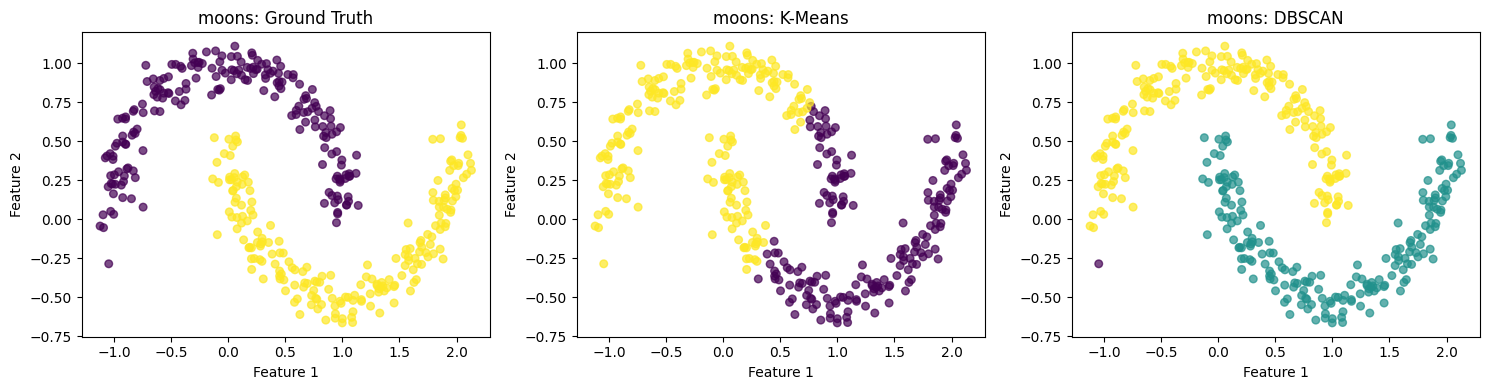

TESTING ON: CIRCLES
Dataset size: 400 samples, 2 features
K-Means Runtime: 0.0175 seconds
K-Means Results:
Number of clusters: 2
Noise points: 0
Silhouette Score: 0.354 (higher is better)
Davies-Bouldin Index: 1.177 (lower is better)
Calinski-Harabasz Score: 232.191 (higher is better)
DBSCAN Runtime: 0.0019 seconds
DBSCAN Results:
Number of clusters: 2
Noise points: 0
Silhouette Score: 0.111 (higher is better)
Davies-Bouldin Index: 331.853 (lower is better)
Calinski-Harabasz Score: 0.003 (higher is better)


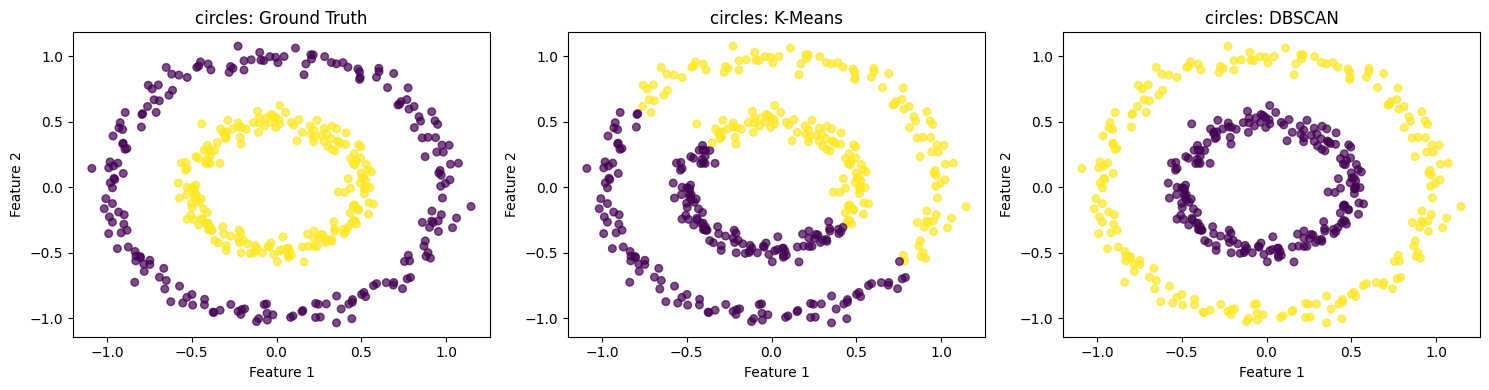

TESTING ON: NOISY_BLOBS
Dataset size: 460 samples, 2 features
K-Means Runtime: 0.0190 seconds
K-Means Results:
Number of clusters: 3
Noise points: 0
Silhouette Score: 0.815 (higher is better)
Davies-Bouldin Index: 0.232 (lower is better)
Calinski-Harabasz Score: 3412.046 (higher is better)
DBSCAN Runtime: 0.0016 seconds
DBSCAN Results:
Number of clusters: 3
Noise points: 84
Silhouette Score: 0.914 (higher is better)
Davies-Bouldin Index: 0.123 (lower is better)
Calinski-Harabasz Score: 20859.916 (higher is better)


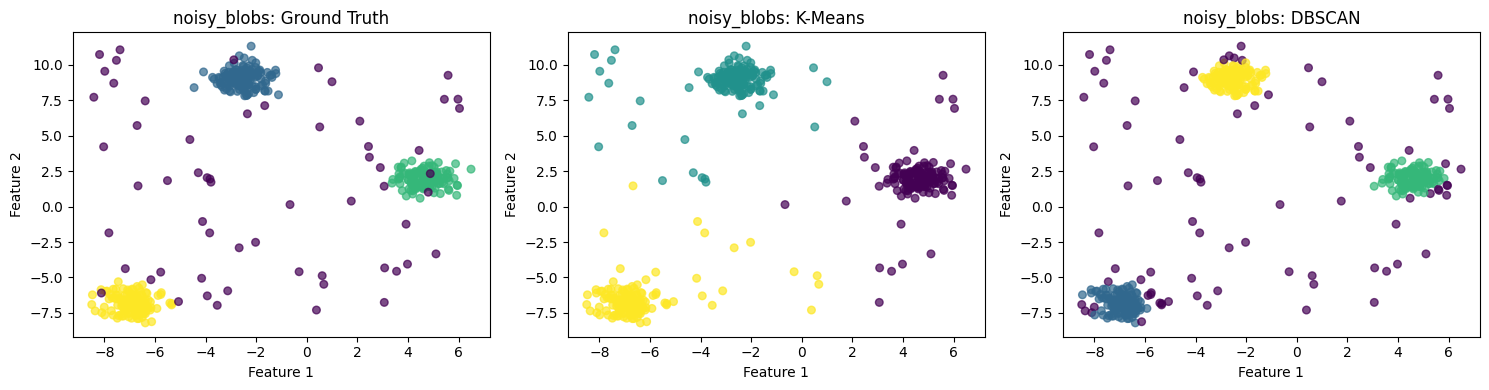

TESTING ON: ANISOTROPIC
Dataset size: 500 samples, 2 features
K-Means Runtime: 0.0186 seconds
K-Means Results:
Number of clusters: 3
Noise points: 0
Silhouette Score: 0.692 (higher is better)
Davies-Bouldin Index: 0.462 (lower is better)
Calinski-Harabasz Score: 5130.669 (higher is better)
DBSCAN Runtime: 0.0020 seconds
DBSCAN Results:
Number of clusters: 3
Noise points: 6
Silhouette Score: 0.697 (higher is better)
Davies-Bouldin Index: 0.458 (lower is better)
Calinski-Harabasz Score: 5445.730 (higher is better)


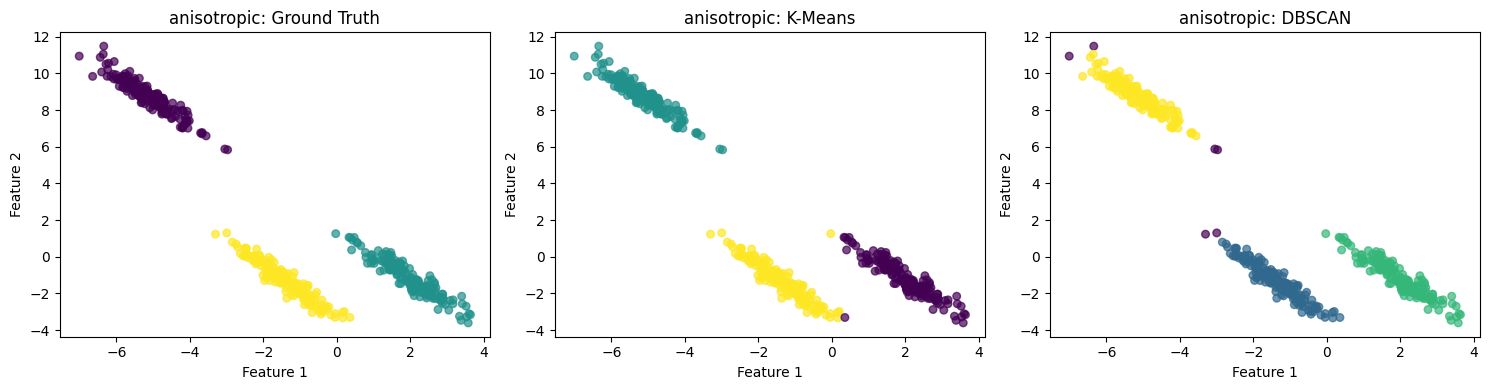

TESTING ON: UNEQUAL_VAR
Dataset size: 500 samples, 2 features
K-Means Runtime: 0.0187 seconds
K-Means Results:
Number of clusters: 3
Noise points: 0
Silhouette Score: 0.814 (higher is better)
Davies-Bouldin Index: 0.316 (lower is better)
Calinski-Harabasz Score: 3721.130 (higher is better)
DBSCAN Runtime: 0.0029 seconds
DBSCAN Results:
Number of clusters: 8
Noise points: 91
Silhouette Score: 0.808 (higher is better)
Davies-Bouldin Index: 0.559 (lower is better)
Calinski-Harabasz Score: 8642.481 (higher is better)


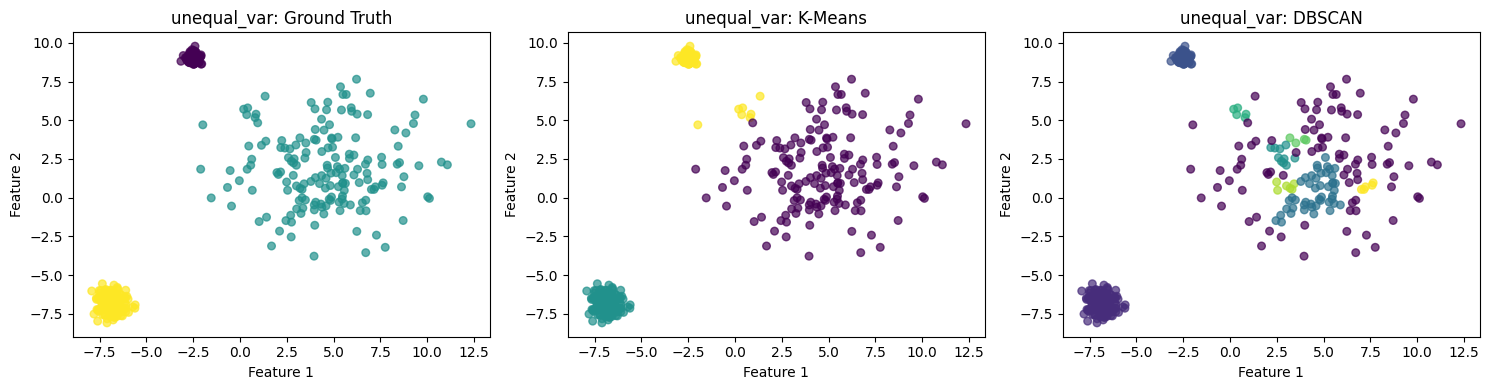

TESTING ON: VARYING_DENSITY
Dataset size: 900 samples, 2 features
K-Means Runtime: 0.0213 seconds
K-Means Results:
Number of clusters: 2
Noise points: 0
Silhouette Score: 0.820 (higher is better)
Davies-Bouldin Index: 0.203 (lower is better)
Calinski-Harabasz Score: 7678.204 (higher is better)
DBSCAN Runtime: 0.0048 seconds
DBSCAN Results:
Number of clusters: 2
Noise points: 9
Silhouette Score: 0.825 (higher is better)
Davies-Bouldin Index: 0.199 (lower is better)
Calinski-Harabasz Score: 8083.773 (higher is better)


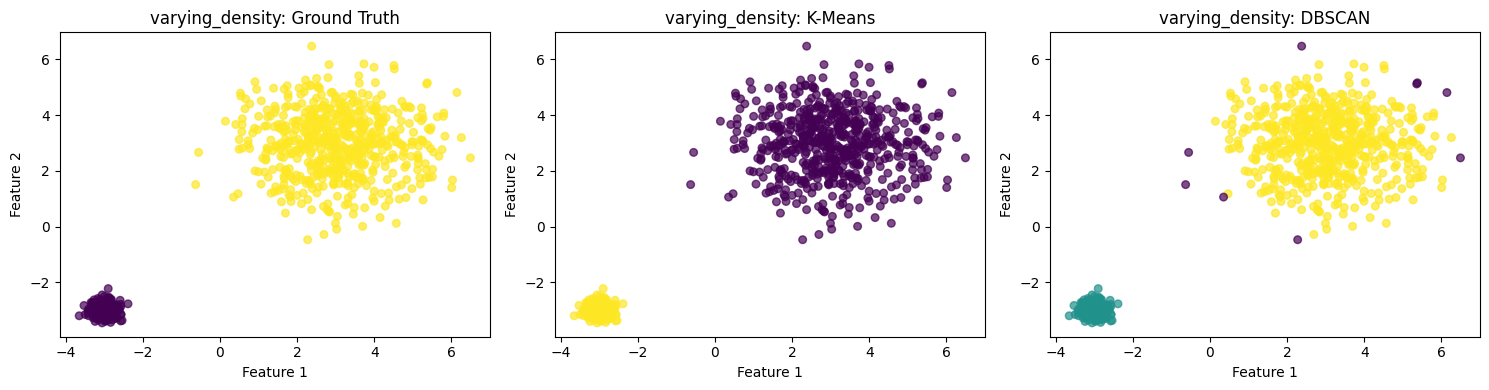

TESTING ON: OVERLAP
Dataset size: 500 samples, 2 features
K-Means Runtime: 0.0174 seconds
K-Means Results:
Number of clusters: 2
Noise points: 0
Silhouette Score: 0.582 (higher is better)
Davies-Bouldin Index: 0.598 (lower is better)
Calinski-Harabasz Score: 1107.834 (higher is better)
DBSCAN Runtime: 0.0019 seconds
DBSCAN Results:
Number of clusters: 2
Noise points: 63
Silhouette Score: 0.097 (higher is better)
Davies-Bouldin Index: 0.765 (lower is better)
Calinski-Harabasz Score: 8.770 (higher is better)


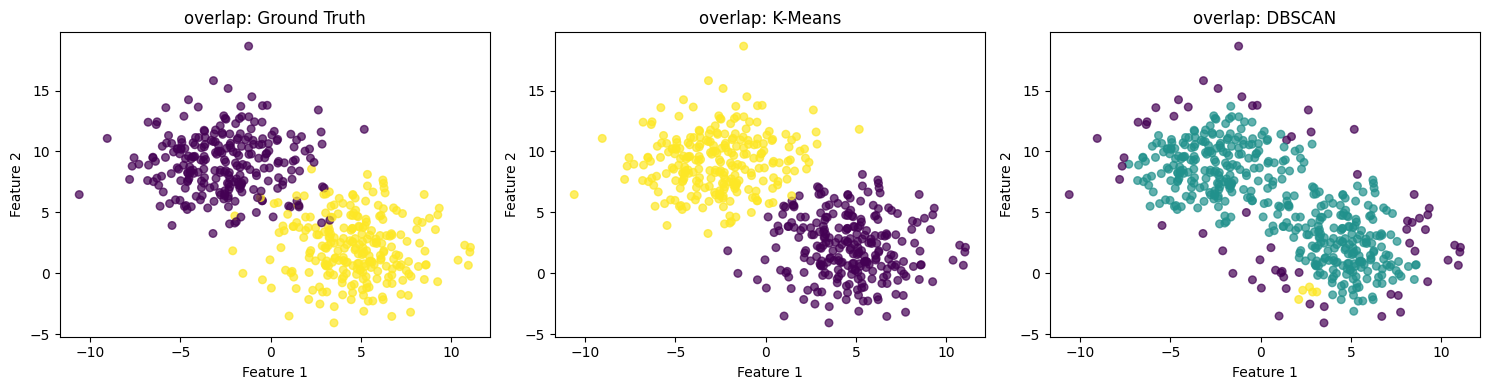

TESTING ON: UNEVEN_BLOBS
Dataset size: 1000 samples, 2 features
K-Means Runtime: 0.0210 seconds
K-Means Results:
Number of clusters: 2
Noise points: 0
Silhouette Score: 0.908 (higher is better)
Davies-Bouldin Index: 0.087 (lower is better)
Calinski-Harabasz Score: 15831.174 (higher is better)
DBSCAN Runtime: 0.0056 seconds
DBSCAN Results:
Number of clusters: 2
Noise points: 5
Silhouette Score: 0.909 (higher is better)
Davies-Bouldin Index: 0.086 (lower is better)
Calinski-Harabasz Score: 16171.513 (higher is better)


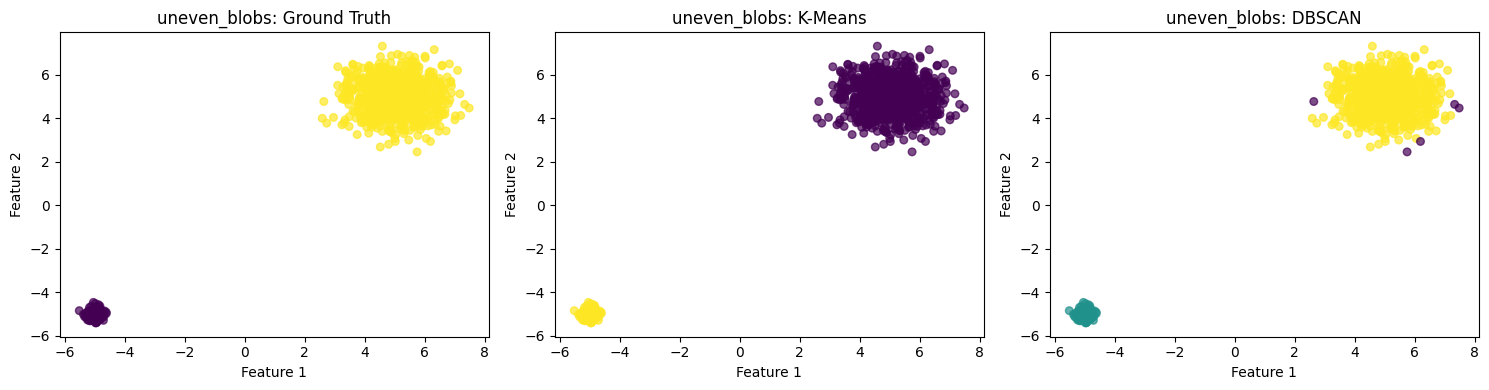

In [5]:
# CHOOSE 2D or 3D HERE
n_features = 2
datasets = generate_datasets(n_features)
test_params_2d = {
    'blobs': {'kmeans_k': 4, 'dbscan_eps': 0.5, 'dbscan_min_samples': 5},
    'moons': {'kmeans_k': 2, 'dbscan_eps': 0.2, 'dbscan_min_samples': 5},
    'circles': {'kmeans_k': 2, 'dbscan_eps': 0.15, 'dbscan_min_samples': 5},
    'noisy_blobs': {'kmeans_k': 3, 'dbscan_eps': 0.4, 'dbscan_min_samples': 5},
    'anisotropic': {'kmeans_k': 3, 'dbscan_eps': 0.5, 'dbscan_min_samples': 5},
    'unequal_var': {'kmeans_k': 3, 'dbscan_eps': 0.6, 'dbscan_min_samples': 5},
    'varying_density': {'kmeans_k': 2, 'dbscan_eps': 0.7, 'dbscan_min_samples': 5},
    'overlap': {'kmeans_k': 2, 'dbscan_eps': 0.9, 'dbscan_min_samples': 5},
    'uneven_blobs': {'kmeans_k': 2, 'dbscan_eps': 0.5, 'dbscan_min_samples': 5}
}
test_params_3d = {
    'blobs': {'kmeans_k': 4, 'dbscan_eps': 0.75, 'dbscan_min_samples': 5},
    'moons': {'kmeans_k': 2, 'dbscan_eps': 0.3, 'dbscan_min_samples': 5},
    'circles': {'kmeans_k': 2, 'dbscan_eps': 0.25, 'dbscan_min_samples': 5},
    'noisy_blobs': {'kmeans_k': 3, 'dbscan_eps': 0.6, 'dbscan_min_samples': 5},
    'anisotropic': {'kmeans_k': 3, 'dbscan_eps': 0.75, 'dbscan_min_samples': 5},
    'unequal_var': {'kmeans_k': 3, 'dbscan_eps': 0.7, 'dbscan_min_samples': 5},
    'varying_density': {'kmeans_k': 2, 'dbscan_eps': 0.85, 'dbscan_min_samples': 5},
    'overlap': {'kmeans_k': 2, 'dbscan_eps': 1.2, 'dbscan_min_samples': 5},
    'uneven_blobs': {'kmeans_k': 2, 'dbscan_eps': 0.75, 'dbscan_min_samples': 5}
}
test_params = test_params_2d if n_features == 2 else test_params_3d

for dataset_name, (X, y_true) in datasets.items():
    print(f"TESTING ON: {dataset_name.upper()}")
    print(f"Dataset size: {X.shape[0]} samples, {X.shape[1]} features")
    
    if dataset_name not in test_params:
        print(f"No test parameters for {dataset_name}, skipping...")
        continue
    
    params = test_params[dataset_name]
    
    # Run K-Means
    labels_km, model_km, runtime_km = run_kmeans(
        X, n_clusters=params['kmeans_k']
    )
    print(f"K-Means Runtime: {runtime_km:.4f} seconds")
    metrics_km = evaluate_clustering(X, labels_km, "K-Means")
    
    # Run DBSCAN
    labels_db, model_db, runtime_db = run_dbscan(
        X, eps=params['dbscan_eps'], min_samples=params['dbscan_min_samples']
    )
    print(f"DBSCAN Runtime: {runtime_db:.4f} seconds")
    metrics_db = evaluate_clustering(X, labels_db, "DBSCAN")
    
    # Visualize results — will plot 3D scatter plots for 3 features
    plot_comparison(X, y_true, labels_km, labels_db, dataset_name)

TESTING ON: BLOBS
Dataset size: 500 samples, 3 features
K-Means Runtime: 0.0236 seconds
K-Means Results:
Number of clusters: 4
Noise points: 0
Silhouette Score: 0.822 (higher is better)
Davies-Bouldin Index: 0.253 (lower is better)
Calinski-Harabasz Score: 11411.134 (higher is better)
DBSCAN Runtime: 0.0021 seconds
DBSCAN Results:
Number of clusters: 4
Noise points: 56
Silhouette Score: 0.835 (higher is better)
Davies-Bouldin Index: 0.233 (lower is better)
Calinski-Harabasz Score: 12686.537 (higher is better)


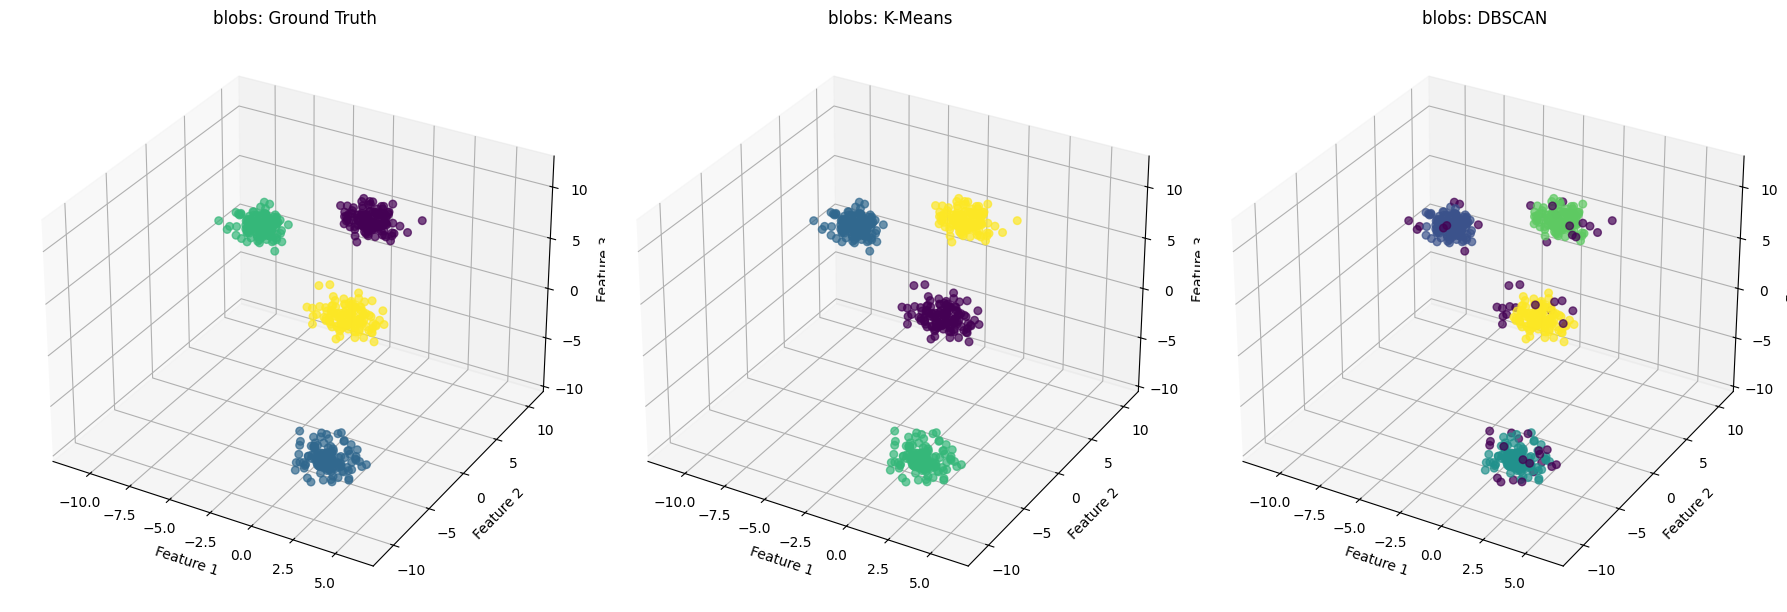

TESTING ON: MOONS
Dataset size: 400 samples, 3 features
K-Means Runtime: 0.0185 seconds
K-Means Results:
Number of clusters: 2
Noise points: 0
Silhouette Score: 0.486 (higher is better)
Davies-Bouldin Index: 0.783 (lower is better)
Calinski-Harabasz Score: 581.145 (higher is better)
DBSCAN Runtime: 0.0023 seconds
DBSCAN Results:
Number of clusters: 1
Noise points: 0
Not enough clusters for quality metrics


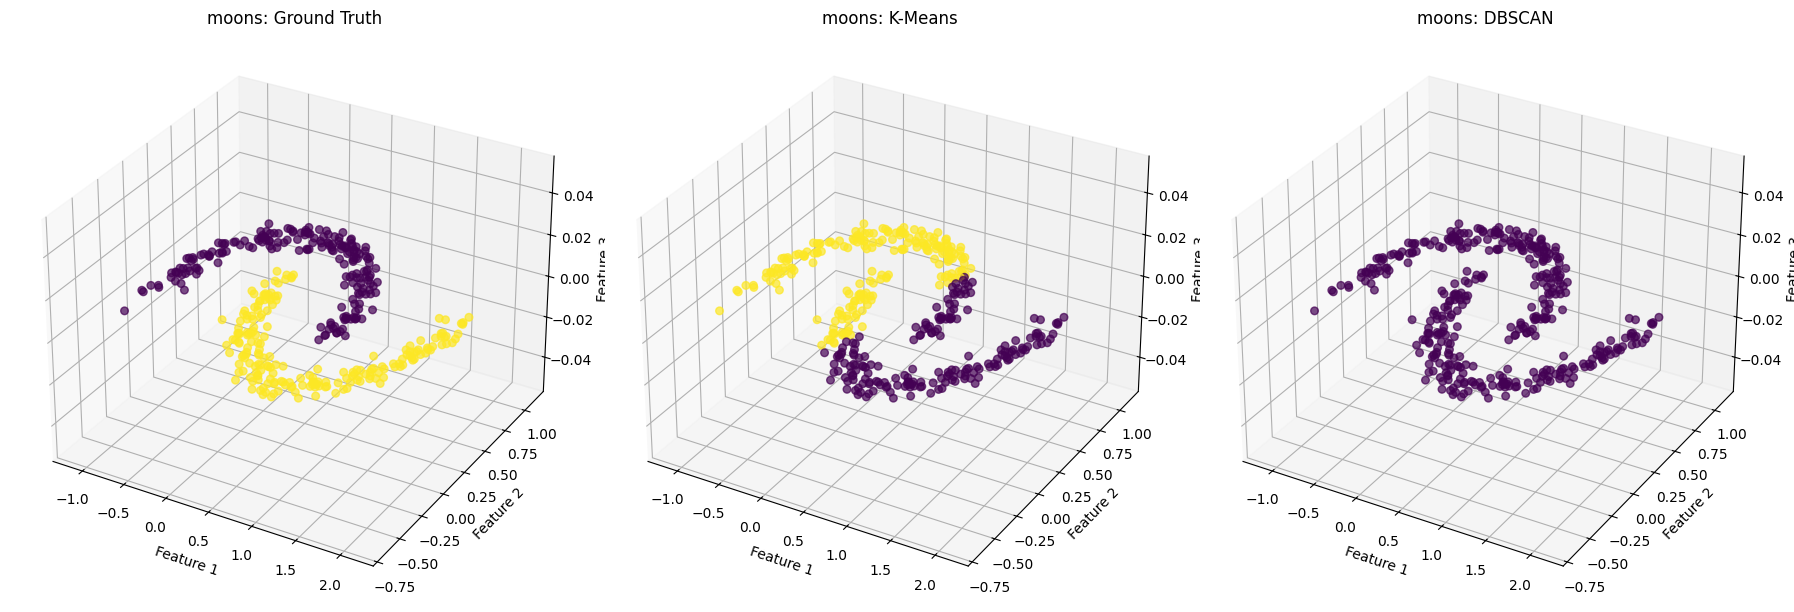

TESTING ON: CIRCLES
Dataset size: 400 samples, 3 features
K-Means Runtime: 0.0182 seconds
K-Means Results:
Number of clusters: 2
Noise points: 0
Silhouette Score: 0.354 (higher is better)
Davies-Bouldin Index: 1.177 (lower is better)
Calinski-Harabasz Score: 232.191 (higher is better)
DBSCAN Runtime: 0.0017 seconds
DBSCAN Results:
Number of clusters: 2
Noise points: 0
Silhouette Score: 0.111 (higher is better)
Davies-Bouldin Index: 331.853 (lower is better)
Calinski-Harabasz Score: 0.003 (higher is better)


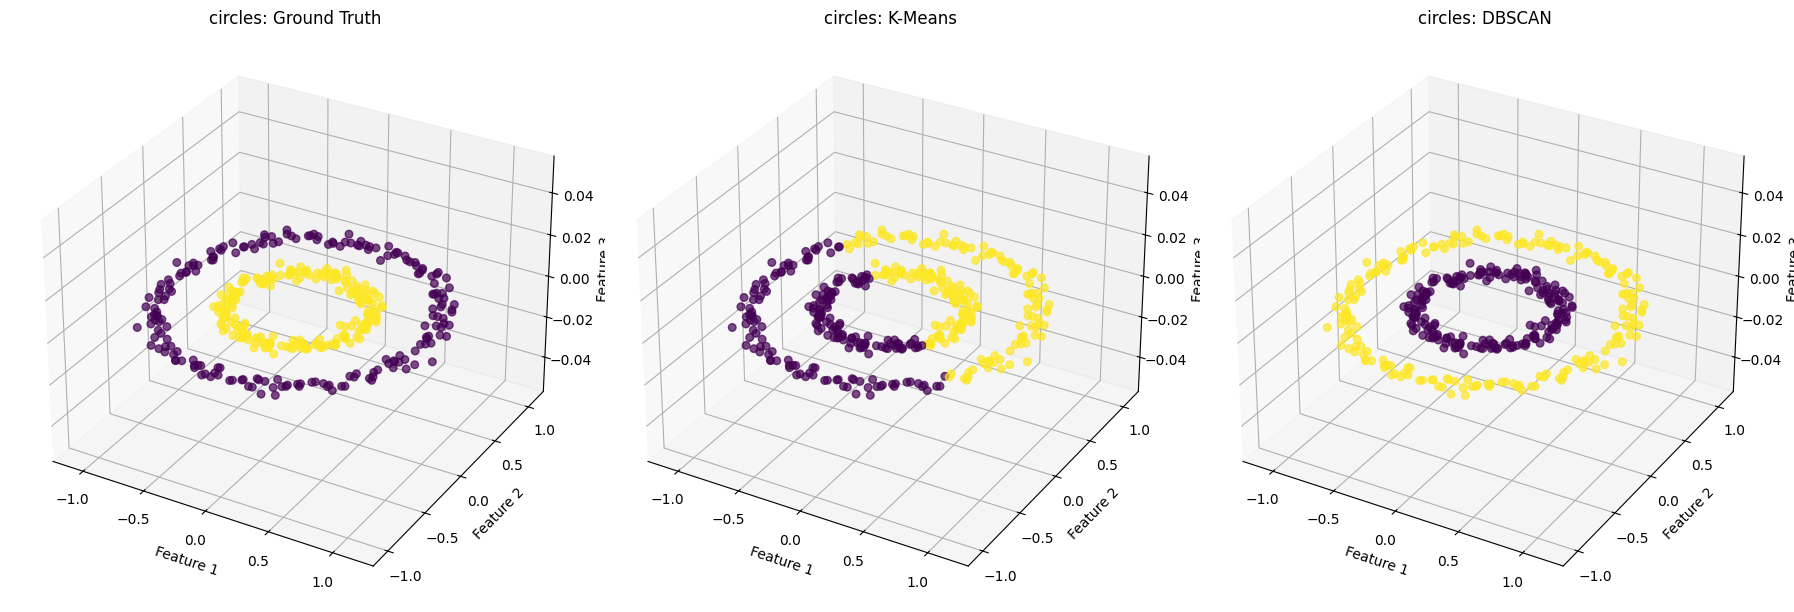

TESTING ON: NOISY_BLOBS
Dataset size: 460 samples, 3 features
K-Means Runtime: 0.0180 seconds
K-Means Results:
Number of clusters: 3
Noise points: 0
Silhouette Score: 0.715 (higher is better)
Davies-Bouldin Index: 0.429 (lower is better)
Calinski-Harabasz Score: 1991.262 (higher is better)
DBSCAN Runtime: 0.0025 seconds
DBSCAN Results:
Number of clusters: 3
Noise points: 98
Silhouette Score: 0.864 (higher is better)
Davies-Bouldin Index: 0.192 (lower is better)
Calinski-Harabasz Score: 19219.471 (higher is better)


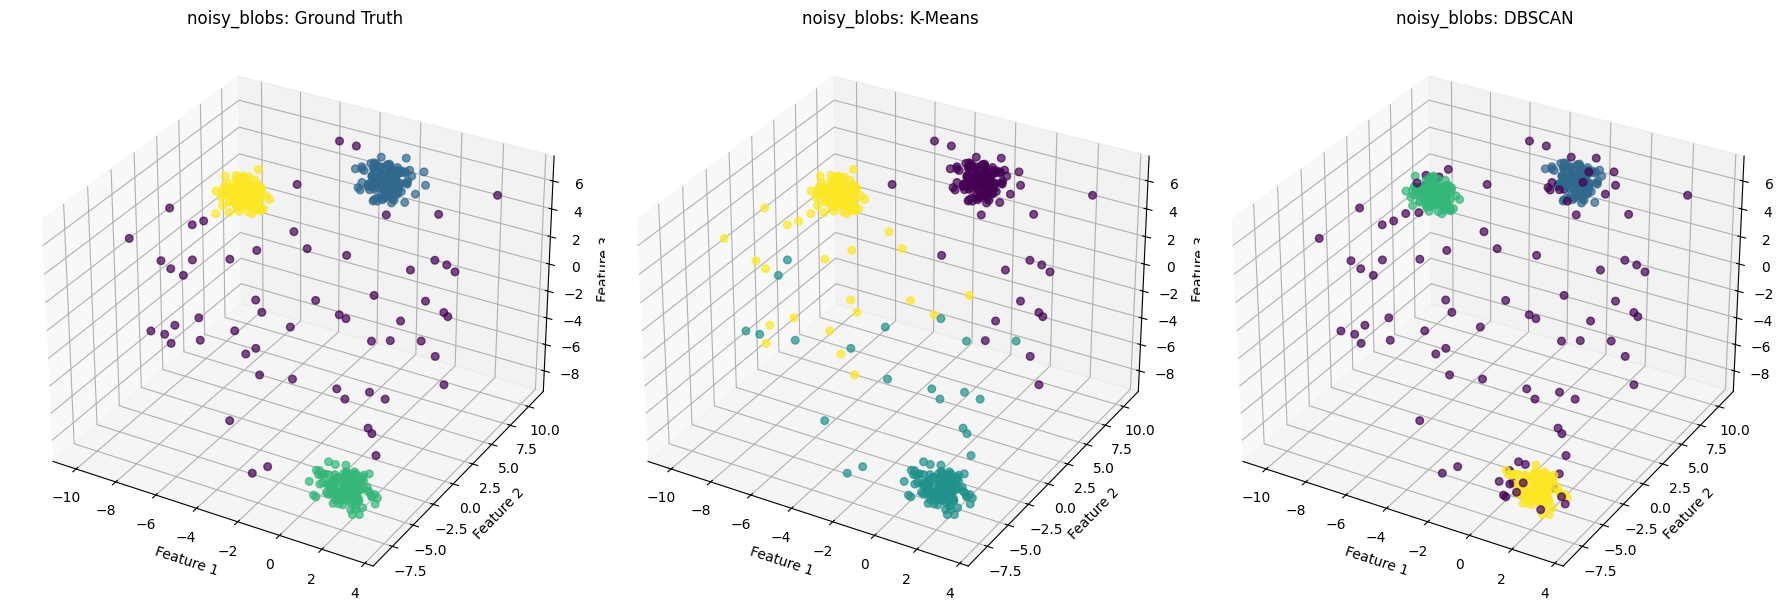

TESTING ON: ANISOTROPIC
Dataset size: 500 samples, 3 features
K-Means Runtime: 0.0191 seconds
K-Means Results:
Number of clusters: 3
Noise points: 0
Silhouette Score: 0.759 (higher is better)
Davies-Bouldin Index: 0.348 (lower is better)
Calinski-Harabasz Score: 8066.799 (higher is better)
DBSCAN Runtime: 0.0029 seconds
DBSCAN Results:
Number of clusters: 4
Noise points: 123
Silhouette Score: 0.578 (higher is better)
Davies-Bouldin Index: 0.588 (lower is better)
Calinski-Harabasz Score: 6563.320 (higher is better)


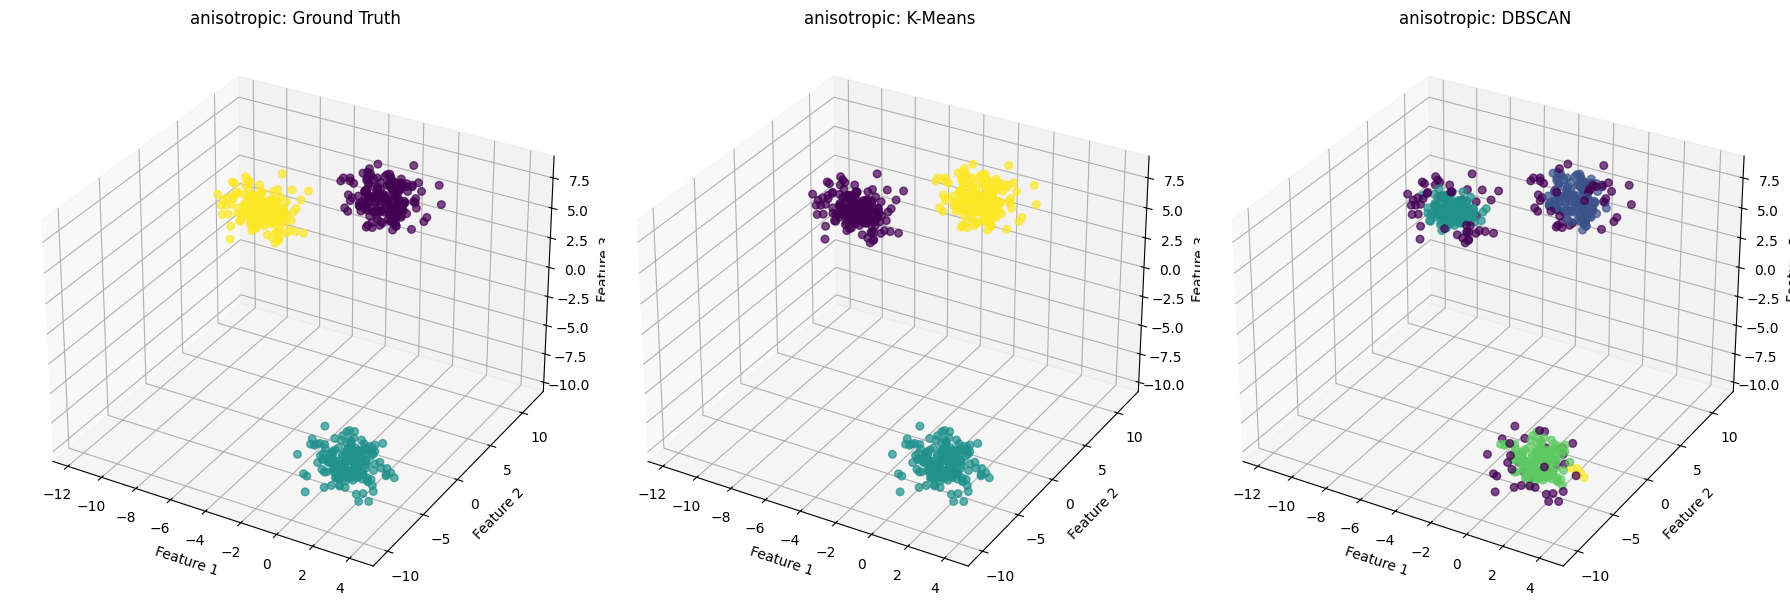

TESTING ON: UNEQUAL_VAR
Dataset size: 500 samples, 3 features
K-Means Runtime: 0.0183 seconds
K-Means Results:
Number of clusters: 3
Noise points: 0
Silhouette Score: 0.759 (higher is better)
Davies-Bouldin Index: 0.348 (lower is better)
Calinski-Harabasz Score: 8066.799 (higher is better)
DBSCAN Runtime: 0.0028 seconds
DBSCAN Results:
Number of clusters: 5
Noise points: 143
Silhouette Score: 0.549 (higher is better)
Davies-Bouldin Index: 0.630 (lower is better)
Calinski-Harabasz Score: 5024.879 (higher is better)


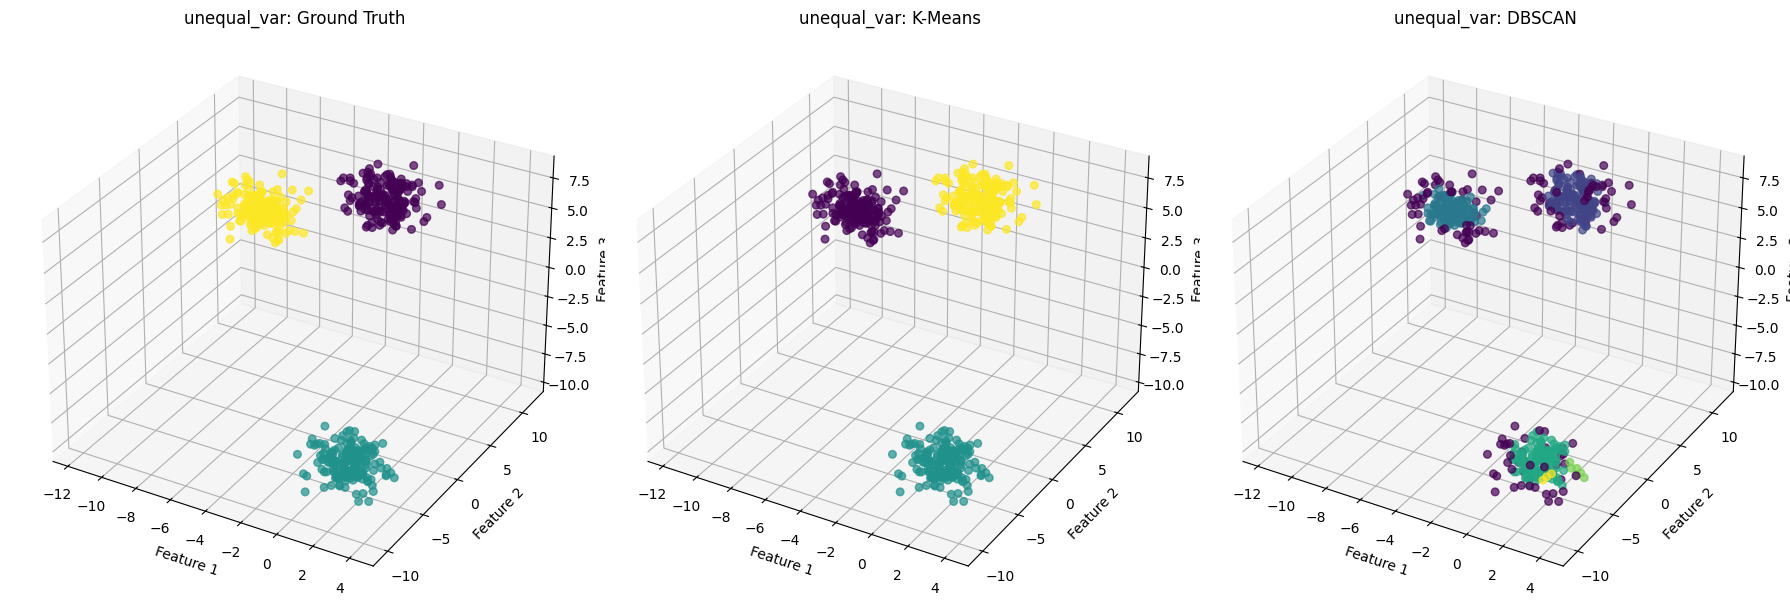

TESTING ON: OVERLAP
Dataset size: 500 samples, 3 features
K-Means Runtime: 0.0172 seconds
K-Means Results:
Number of clusters: 2
Noise points: 0
Silhouette Score: 0.722 (higher is better)
Davies-Bouldin Index: 0.398 (lower is better)
Calinski-Harabasz Score: 2648.155 (higher is better)
DBSCAN Runtime: 0.0029 seconds
DBSCAN Results:
Number of clusters: 6
Noise points: 277
Silhouette Score: 0.189 (higher is better)
Davies-Bouldin Index: 0.808 (lower is better)
Calinski-Harabasz Score: 665.242 (higher is better)


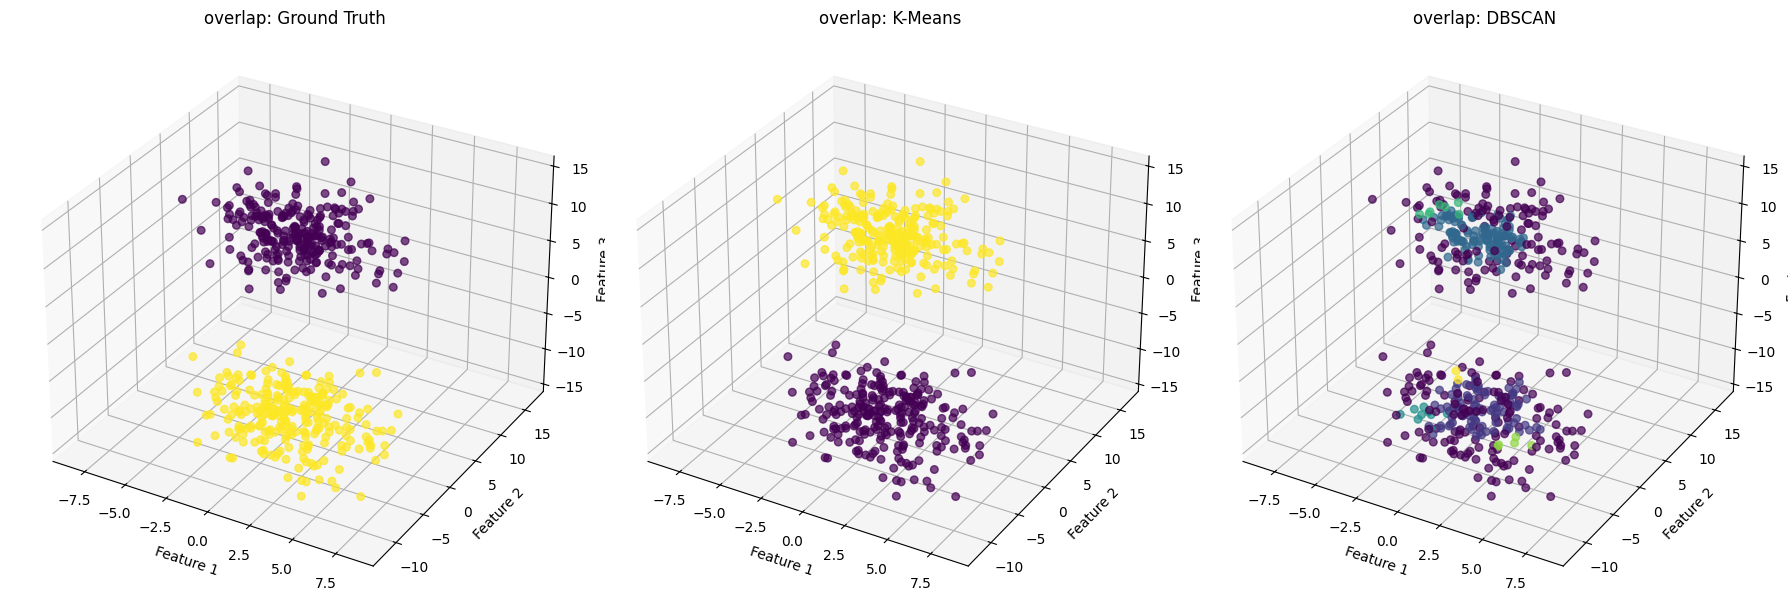

TESTING ON: UNEVEN_BLOBS
Dataset size: 1000 samples, 3 features
K-Means Runtime: 0.0210 seconds
K-Means Results:
Number of clusters: 2
Noise points: 0
Silhouette Score: 0.904 (higher is better)
Davies-Bouldin Index: 0.091 (lower is better)
Calinski-Harabasz Score: 15762.689 (higher is better)
DBSCAN Runtime: 0.0106 seconds
DBSCAN Results:
Number of clusters: 2
Noise points: 9
Silhouette Score: 0.906 (higher is better)
Davies-Bouldin Index: 0.090 (lower is better)
Calinski-Harabasz Score: 16205.415 (higher is better)


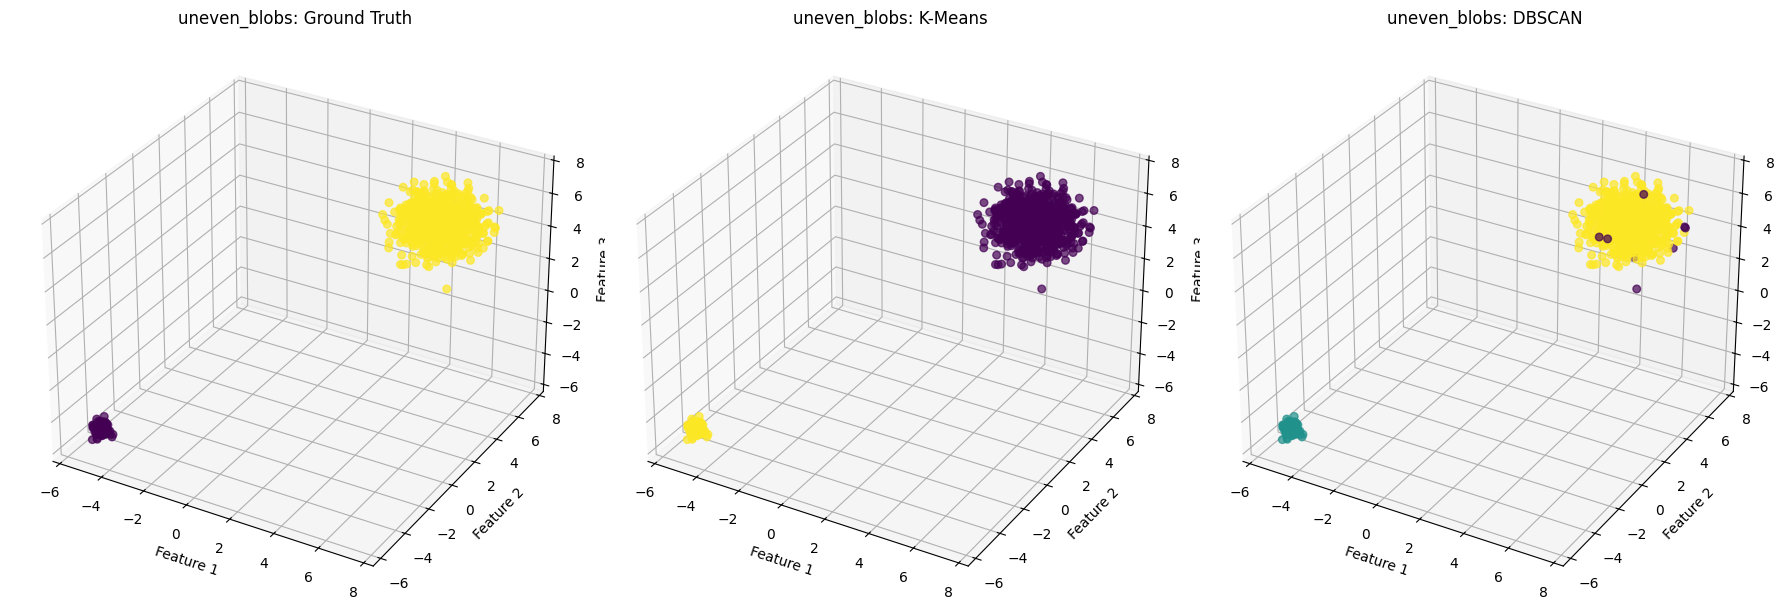

In [6]:
# CHOOSE 2D or 3D HERE
n_features = 3
datasets = generate_datasets(n_features)
test_params_2d = {
    'blobs': {'kmeans_k': 4, 'dbscan_eps': 0.5, 'dbscan_min_samples': 5},
    'moons': {'kmeans_k': 2, 'dbscan_eps': 0.2, 'dbscan_min_samples': 5},
    'circles': {'kmeans_k': 2, 'dbscan_eps': 0.15, 'dbscan_min_samples': 5},
    'noisy_blobs': {'kmeans_k': 3, 'dbscan_eps': 0.4, 'dbscan_min_samples': 5},
    'anisotropic': {'kmeans_k': 3, 'dbscan_eps': 0.5, 'dbscan_min_samples': 5},
    'unequal_var': {'kmeans_k': 3, 'dbscan_eps': 0.6, 'dbscan_min_samples': 5},
    'varying_density': {'kmeans_k': 2, 'dbscan_eps': 0.7, 'dbscan_min_samples': 5},
    'overlap': {'kmeans_k': 2, 'dbscan_eps': 0.9, 'dbscan_min_samples': 5},
    'uneven_blobs': {'kmeans_k': 2, 'dbscan_eps': 0.5, 'dbscan_min_samples': 5}
}
test_params_3d = {
    'blobs': {'kmeans_k': 4, 'dbscan_eps': 0.75, 'dbscan_min_samples': 5},
    'moons': {'kmeans_k': 2, 'dbscan_eps': 0.3, 'dbscan_min_samples': 5},
    'circles': {'kmeans_k': 2, 'dbscan_eps': 0.25, 'dbscan_min_samples': 5},
    'noisy_blobs': {'kmeans_k': 3, 'dbscan_eps': 0.6, 'dbscan_min_samples': 5},
    'anisotropic': {'kmeans_k': 3, 'dbscan_eps': 0.75, 'dbscan_min_samples': 5},
    'unequal_var': {'kmeans_k': 3, 'dbscan_eps': 0.7, 'dbscan_min_samples': 5},
    'varying_density': {'kmeans_k': 2, 'dbscan_eps': 0.85, 'dbscan_min_samples': 5},
    'overlap': {'kmeans_k': 2, 'dbscan_eps': 1.2, 'dbscan_min_samples': 5},
    'uneven_blobs': {'kmeans_k': 2, 'dbscan_eps': 0.75, 'dbscan_min_samples': 5}
}
test_params = test_params_2d if n_features == 2 else test_params_3d

for dataset_name, (X, y_true) in datasets.items():
    print(f"TESTING ON: {dataset_name.upper()}")
    print(f"Dataset size: {X.shape[0]} samples, {X.shape[1]} features")
    
    if dataset_name not in test_params:
        print(f"No test parameters for {dataset_name}, skipping...")
        continue
    
    params = test_params[dataset_name]
    
    # Run K-Means
    labels_km, model_km, runtime_km = run_kmeans(
        X, n_clusters=params['kmeans_k']
    )
    print(f"K-Means Runtime: {runtime_km:.4f} seconds")
    metrics_km = evaluate_clustering(X, labels_km, "K-Means")
    
    # Run DBSCAN
    labels_db, model_db, runtime_db = run_dbscan(
        X, eps=params['dbscan_eps'], min_samples=params['dbscan_min_samples']
    )
    print(f"DBSCAN Runtime: {runtime_db:.4f} seconds")
    metrics_db = evaluate_clustering(X, labels_db, "DBSCAN")
    
    # Visualize results — will plot 3D scatter plots for 3 features
    plot_comparison(X, y_true, labels_km, labels_db, dataset_name)

1. Measure runtime as dataset size increases (50 to 50,000 samples)
2. Fit complexity models (O(n), O(n log n), O(n²)) to real timing data
3. Identify performance crossover point
4. Visualize scaling behavior

experiment should result in something like

1. K-Means exhibits O(n) linear complexity - runtime scales linearly with dataset size
2. DBSCAN exhibits O(n²) quadratic complexity - runtime scales quadratically without spatial indexing
3. Crossover point is around xx samples where K-Means becomes faster
4. At large scale (50,000 samples), K-Means is xx faster than DBSCAN

K-MEANS vs DBSCAN: TIME COMPLEXITY ANALYSIS
Testing 16 different dataset sizes
Range: 1,000 to 200,000 samples
RUNNING EXPERIMENT: BLOBS
Generating synthetic datasets...
Testing n=1,000 samples... K-Means:  39.17ms | DBSCAN:    7.37ms | Ratio:  0.19x
Testing n=2,000 samples... K-Means:  20.56ms | DBSCAN:   14.16ms | Ratio:  0.69x
Testing n=3,000 samples... K-Means:  16.71ms | DBSCAN:   19.18ms | Ratio:  1.15x
Testing n=5,000 samples... K-Means:  14.68ms | DBSCAN:   29.44ms | Ratio:  2.00x
Testing n=7,500 samples... K-Means:  15.00ms | DBSCAN:   47.54ms | Ratio:  3.17x
Testing n=10,000 samples... K-Means:  19.35ms | DBSCAN:   81.46ms | Ratio:  4.21x
Testing n=15,000 samples... K-Means:  41.29ms | DBSCAN:  107.35ms | Ratio:  2.60x
Testing n=20,000 samples... K-Means:  47.30ms | DBSCAN:  166.63ms | Ratio:  3.52x
Testing n=30,000 samples... K-Means:  69.25ms | DBSCAN:  268.81ms | Ratio:  3.88x
Testing n=50,000 samples... K-Means: 128.40ms | DBSCAN:  526.59ms | Ratio:  4.10x
Testing n=75,00

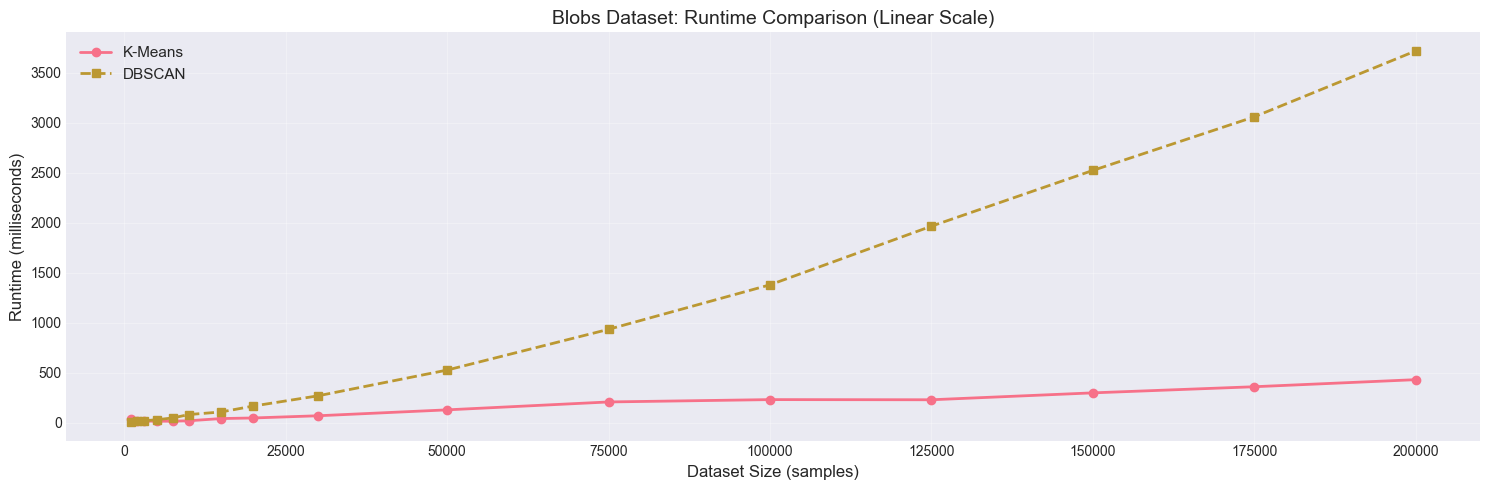

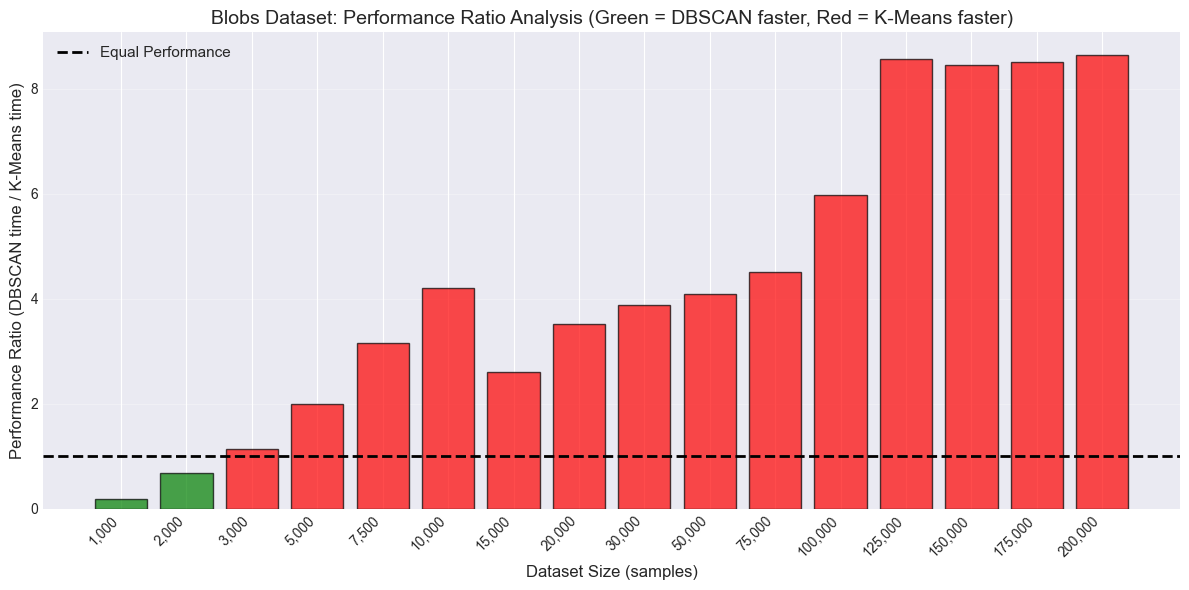

K-MEANS COMPLEXITY ANALYSIS:
--------------------------------------------------------------------------------


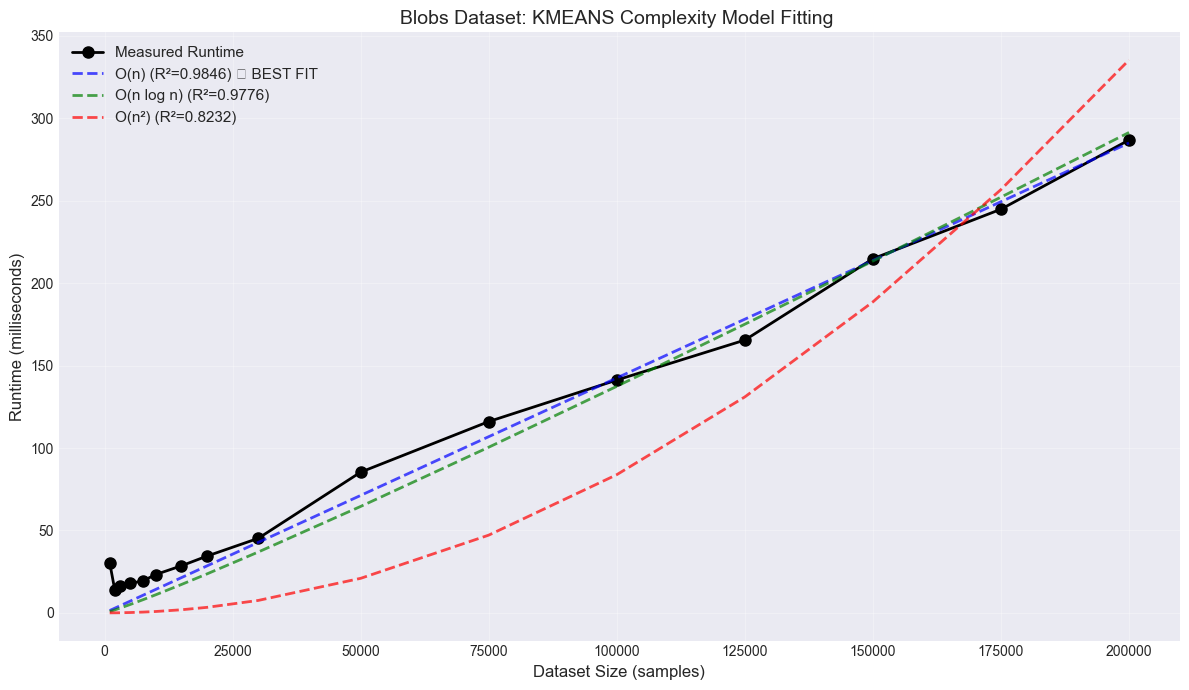

Best fit for K-Means: O(n)
  O(n): R² = 0.984599, coefficient = 1.43e-06
  O(n log n): R² = 0.977625, coefficient = 1.19e-07
  O(n²): R² = 0.823169, coefficient = 8.39e-12
DBSCAN COMPLEXITY ANALYSIS:


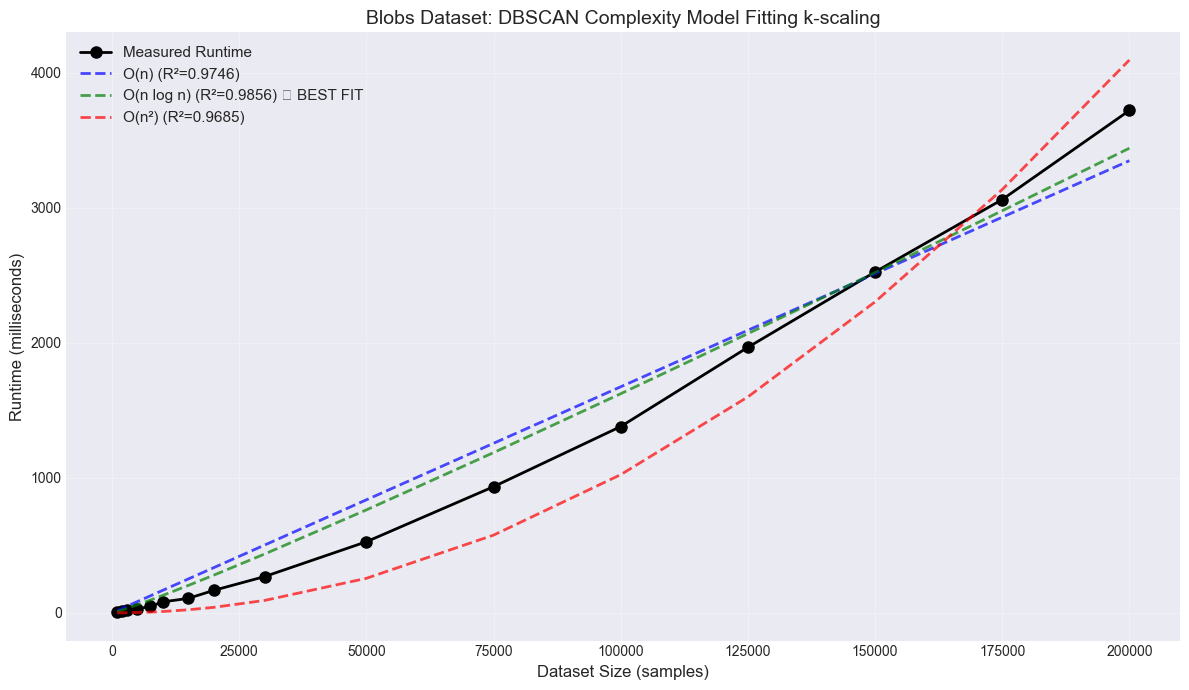

Best fit for DBSCAN: O(n log n)
  O(n): R² = 0.974626, coefficient = 1.67e-05
  O(n log n): R² = 0.985581, coefficient = 1.41e-06
  O(n²): R² = 0.968472, coefficient = 1.02e-10
DBSCAN COMPLEXITY ANALYSIS:


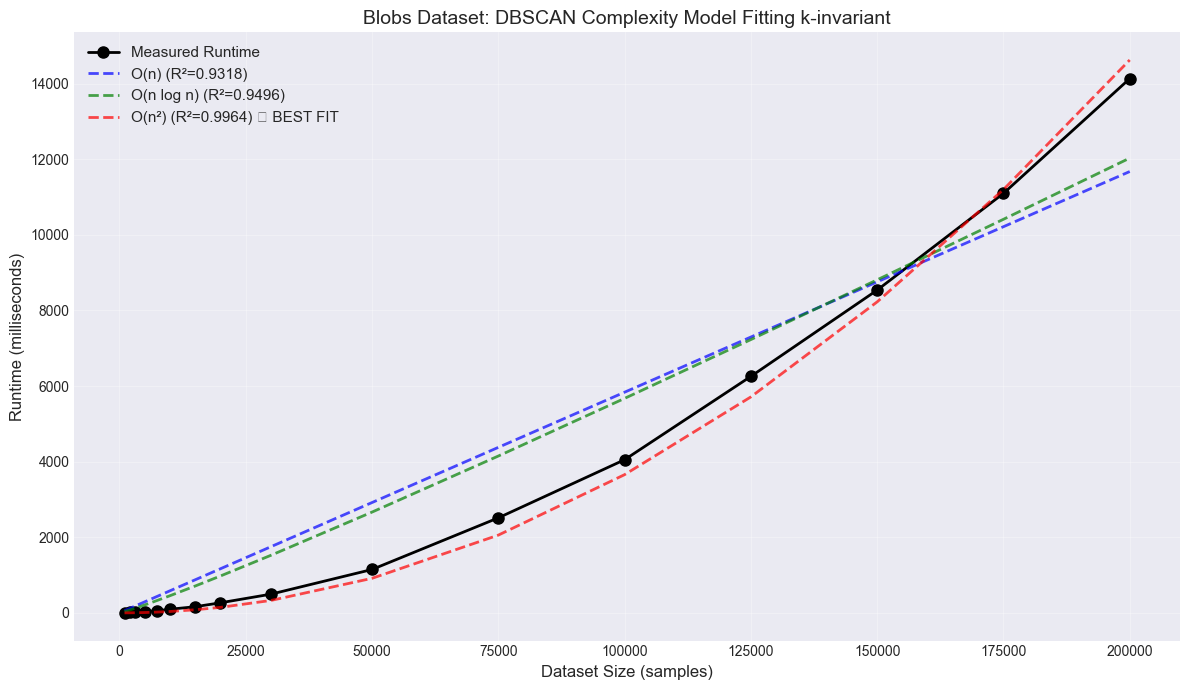

Best fit for DBSCAN: O(n²)
  O(n): R² = 0.931811, coefficient = 5.84e-05
  O(n log n): R² = 0.949566, coefficient = 4.93e-06
  O(n²): R² = 0.996392, coefficient = 3.66e-10
 Sample_Size  KMeans_ms  DBSCAN_ms  Performance_Ratio  Winner
        1000      39.17       7.37               0.19  DBSCAN
        2000      20.56      14.16               0.69  DBSCAN
        3000      16.71      19.18               1.15 K-Means
        5000      14.68      29.44               2.00 K-Means
        7500      15.00      47.54               3.17 K-Means
       10000      19.35      81.46               4.21 K-Means
       15000      41.29     107.35               2.60 K-Means
       20000      47.30     166.63               3.52 K-Means
       30000      69.25     268.81               3.88 K-Means
       50000     128.40     526.59               4.10 K-Means
       75000     207.51     934.34               4.50 K-Means
      100000     230.98    1379.66               5.97 K-Means
      125000     229.3

In [11]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def generate_scaling_datasets(sample_sizes, scaling=False):
    datasets = {
        'blobs': [],
        'moons': [],
        'circles': []
    }
    print("Generating synthetic datasets...")
    for size in sample_sizes:
        # Set clusters proportional to data size (approx 1 cluster per 1000 points)
        n_clusters = max(1, size // 1000) if scaling else 5

        X_blobs, _ = make_blobs(
            n_samples=size,
            centers=n_clusters,
            n_features=2,
            cluster_std=0.8,
            random_state=42
        )
        datasets['blobs'].append((size, X_blobs))

        X_moons, _ = make_moons(n_samples=size, noise=0.08, random_state=42)
        datasets['moons'].append((size, X_moons))
        
        X_circles, _ = make_circles(n_samples=size, noise=0.05, factor=0.5, random_state=42)
        datasets['circles'].append((size, X_circles))

    return datasets

def benchmark_algorithm(algorithm, X, params, n_runs=3):
    """
    Benchmark clustering algorithm with multiple runs.
    
    Parameters:
    -----------
    algorithm : class
        Clustering algorithm class (KMeans or DBSCAN)
    X : array-like
        Input data
    params : dict
        Algorithm parameters
    n_runs : int
        Number of runs for averaging
    
    Returns:
    --------
    tuple : (mean_time, std_time, labels)
    """
    times = []
    labels = None
    
    for _ in range(n_runs):
        start = time.perf_counter()
        model = algorithm(**params)
        labels = model.fit_predict(X)
        elapsed = time.perf_counter() - start
        times.append(elapsed)
    
    return np.mean(times), np.std(times), labels

def run_complexity_experiment(sample_sizes, dataset_type='blobs', scaling_k=True):
    """
    Run complete complexity experiment for a specific dataset type.
    
    Parameters:
    -----------
    sample_sizes : list
        List of sample sizes to test
    dataset_type : str
        Type of dataset ('blobs', 'moons', or 'circles')
    
    Returns:
    --------
    pd.DataFrame : Results with timing data
    """
    print(f"RUNNING EXPERIMENT: {dataset_type.upper()}")
    
    # Generate datasets
    datasets = generate_scaling_datasets(sample_sizes, scaling_k)
    
    # Algorithm parameters
    params_map = {
        'blobs': {'kmeans': {'n_clusters': 5}, 'dbscan': {'eps': 0.5, 'min_samples': 5}},
        'moons': {'kmeans': {'n_clusters': 2}, 'dbscan': {'eps': 0.2, 'min_samples': 5}},
        'circles': {'kmeans': {'n_clusters': 2}, 'dbscan': {'eps': 0.15, 'min_samples': 5}}
    }
    
    params = params_map[dataset_type]
    results = []
    
    for size, X in datasets[dataset_type]:
        print(f"Testing n={size:,} samples...", end=" ")
        
        # Benchmark K-Means
        km_params = {**params['kmeans'], 'init': 'k-means++', 'n_init': 10, 
                     'max_iter': 300, 'random_state': 42}
        km_time, km_std, km_labels = benchmark_algorithm(KMeans, X, km_params, n_runs=3)
        
        # Benchmark DBSCAN
        db_params = {**params['dbscan'], 'metric': 'euclidean'}
        db_time, db_std, db_labels = benchmark_algorithm(DBSCAN, X, db_params, n_runs=3)
        
        # Calculate metrics
        ratio = db_time / km_time if km_time > 0 else 0
        
        print(f"K-Means: {km_time*1000:6.2f}ms | DBSCAN: {db_time*1000:7.2f}ms | Ratio: {ratio:5.2f}x")
        
        results.append({
            'sample_size': size,
            'kmeans_time_sec': km_time,
            'kmeans_std_sec': km_std,
            'dbscan_time_sec': db_time,
            'dbscan_std_sec': db_std,
            'ratio': ratio
        })
    
    return pd.DataFrame(results)

def linear(n, a):
    """O(n) complexity model"""
    return a * n

def nlogn(n, a):
    """O(n log n) complexity model"""
    return a * n * np.log(n)

def quadratic(n, a):
    """O(n²) complexity model"""
    return a * n**2

def r_squared(y_actual, y_predicted):
    """Calculate R² score"""
    ss_res = np.sum((y_actual - y_predicted)**2)
    ss_tot = np.sum((y_actual - np.mean(y_actual))**2)
    return 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

def fit_complexity_models(df, algorithm='kmeans'):
    """
    Fit a few complexity models. Easier but less accurate than sklearn fit
    
    Parameters:
    -----------
    df : pd.DataFrame
        Results dataframe with timing data
    algorithm : str
        'kmeans' or 'dbscan'
    
    Returns:
    --------
    dict : Fitted models and R² scores
    """
    sizes = df['sample_size'].values
    times = df[f'{algorithm}_time_sec'].values
    
    fits = {}
    
    # Fit O(n)
    try:
        popt_lin, _ = curve_fit(linear, sizes, times, p0=[1e-6], maxfev=10000)
        pred_lin = linear(sizes, *popt_lin)
        fits['O(n)'] = {
            'r2': r_squared(times, pred_lin),
            'coef': popt_lin[0],
            'pred': pred_lin
        }
    except:
        fits['O(n)'] = {'r2': -1, 'coef': None, 'pred': None}
    
    # Fit O(n log n)
    try:
        popt_nlogn, _ = curve_fit(nlogn, sizes, times, p0=[1e-6], maxfev=10000)
        pred_nlogn = nlogn(sizes, *popt_nlogn)
        fits['O(n log n)'] = {
            'r2': r_squared(times, pred_nlogn),
            'coef': popt_nlogn[0],
            'pred': pred_nlogn
        }
    except:
        fits['O(n log n)'] = {'r2': -1, 'coef': None, 'pred': None}
    
    # Fit O(n²)
    try:
        popt_quad, _ = curve_fit(quadratic, sizes, times, p0=[1e-8], maxfev=10000)
        pred_quad = quadratic(sizes, *popt_quad)
        fits['O(n²)'] = {
            'r2': r_squared(times, pred_quad),
            'coef': popt_quad[0],
            'pred': pred_quad
        }
    except:
        fits['O(n²)'] = {'r2': -1, 'coef': None, 'pred': None}
    
    # Find best fit
    best_model = max(fits.keys(), key=lambda k: fits[k]['r2'])
    
    return fits, best_model

def plot_runtime_comparison(df, dataset_name='Dataset'):
    """Plot runtime comparison between K-Means and DBSCAN"""
    plt.figure(figsize=(15, 5))
    
    sizes = df['sample_size']
    km_times = df['kmeans_time_sec'] * 1000  # Convert to ms
    db_times = df['dbscan_time_sec'] * 1000
    
    # Linear scale plot
    plt.plot(sizes, km_times, 'o-', label='K-Means', linewidth=2, markersize=6)
    plt.plot(sizes, db_times, 's--', label='DBSCAN', linewidth=2, markersize=6)
    plt.xlabel('Dataset Size (samples)', fontsize=12)
    plt.ylabel('Runtime (milliseconds)', fontsize=12)
    plt.title(f'{dataset_name}: Runtime Comparison (Linear Scale)', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Log-log scale plot is unhelpful -- the complexities are polynomial, not superpolynomial
    # ax2.loglog(sizes, km_times, 'o-', label='K-Means', linewidth=2, markersize=6)
    # ax2.loglog(sizes, db_times, 's--', label='DBSCAN', linewidth=2, markersize=6)
    # ax2.set_xlabel('Dataset Size (samples)', fontsize=12)
    # ax2.set_ylabel('Runtime (milliseconds)', fontsize=12)
    # ax2.set_title(f'{dataset_name}: Runtime Comparison (Log-Log Scale)', fontsize=14)
    # ax2.legend(fontsize=11)
    # ax2.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.savefig(f'out/runtime-comparison-{dataset_name}.png')
    plt.show()

def plot_ratio_analysis(df, dataset_name='Dataset'):
    """Plot performance ratio (DBSCAN/K-Means) over dataset size"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sizes = df['sample_size']
    ratios = df['ratio']
    
    colors = ['green' if r < 1 else 'red' for r in ratios]
    ax.bar(range(len(sizes)), ratios, color=colors, alpha=0.7, edgecolor='black')
    ax.axhline(y=1, color='black', linestyle='--', linewidth=2, label='Equal Performance')
    
    ax.set_xticks(range(len(sizes)))
    ax.set_xticklabels([f'{s:,}' for s in sizes], rotation=45, ha='right')
    ax.set_xlabel('Dataset Size (samples)', fontsize=12)
    ax.set_ylabel('Performance Ratio (DBSCAN time / K-Means time)', fontsize=12)
    ax.set_title(f'{dataset_name}: Performance Ratio Analysis (Green = DBSCAN faster, Red = K-Means faster)', 
                 fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f'out/ratio-analysis-{dataset_name}.png')
    plt.show()

def plot_complexity_fitting(df, algorithm='kmeans', dataset_name='Dataset', extra_label=''):
    """Plot complexity model fitting"""
    sizes = df['sample_size'].values
    times = df[f'{algorithm}_time_sec'].values * 1000  # Convert to ms
    
    fits, best_model = fit_complexity_models(df, algorithm)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Plot actual data
    ax.plot(sizes, times, 'ko-', label='Measured Runtime', markersize=8, linewidth=2)
    
    # Plot fitted models
    colors = {'O(n)': 'blue', 'O(n log n)': 'green', 'O(n²)': 'red'}
    for model, fit_data in fits.items():
        if fit_data['pred'] is not None:
            label = f"{model} (R²={fit_data['r2']:.4f})"
            if model == best_model:
                label += " ★ BEST FIT"
            ax.plot(sizes, fit_data['pred'] * 1000, '--', 
                   color=colors.get(model, 'gray'), 
                   linewidth=2, label=label, alpha=0.7)
    
    ax.set_xlabel('Dataset Size (samples)', fontsize=12)
    ax.set_ylabel('Runtime (milliseconds)', fontsize=12)
    ax.set_title(f'{dataset_name}: {algorithm.upper()} Complexity Model Fitting {extra_label}', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'out/complexity-fitting-{algorithm}.png')
    plt.show()
    
    return fits, best_model

sample_sizes = [1000, 2000, 3000, 5000, 7500, 10000, 15000, 20000, 30000, 50000, 75000, 100000, 125000, 150000, 175000, 200000]
# sample_sizes = [100, 500, 1000, 2000, 3000, 5000, 7500, 10000, 15000, 20000, 30000, 50000, 75000, 100000, 200000, 300000]   # run until out of memory, my pc couldnt handle 400k

print("K-MEANS vs DBSCAN: TIME COMPLEXITY ANALYSIS")
print(f"Testing {len(sample_sizes)} different dataset sizes")
print(f"Range: {min(sample_sizes):,} to {max(sample_sizes):,} samples")

df_blobs = run_complexity_experiment(sample_sizes, dataset_type='blobs')
df_blobs_invariant = run_complexity_experiment(sample_sizes, dataset_type='blobs', scaling_k=False)

# Display results
print("BLOBS DATASET RESULTS")
print(df_blobs.to_string(index=False))

# Save to CSV
df_blobs.to_csv('out/complexity_blobs_results.csv', index=False)

plot_runtime_comparison(df_blobs, dataset_name='Blobs Dataset')
plot_ratio_analysis(df_blobs, dataset_name='Blobs Dataset')
print("K-MEANS COMPLEXITY ANALYSIS:")
print("-" * 80)
km_fits, km_best = plot_complexity_fitting(df_blobs_invariant, algorithm='kmeans', dataset_name='Blobs Dataset')
print(f"Best fit for K-Means: {km_best}")
for model, data in km_fits.items():
    if data['r2'] > -1:
        print(f"  {model}: R² = {data['r2']:.6f}, coefficient = {data['coef']:.2e}")

print("DBSCAN COMPLEXITY ANALYSIS:")
print("="*80)
db_fits, db_best = plot_complexity_fitting(df_blobs, algorithm='dbscan', dataset_name='Blobs Dataset', extra_label='k-scaling')
print(f"Best fit for DBSCAN: {db_best}")
for model, data in db_fits.items():
    if data['r2'] > -1:
        print(f"  {model}: R² = {data['r2']:.6f}, coefficient = {data['coef']:.2e}")

print("DBSCAN COMPLEXITY ANALYSIS:")
print("="*80)
db_fits, db_best = plot_complexity_fitting(df_blobs_invariant, algorithm='dbscan', dataset_name='Blobs Dataset', extra_label='k-invariant')
print(f"Best fit for DBSCAN: {db_best}")
for model, data in db_fits.items():
    if data['r2'] > -1:
        print(f"  {model}: R² = {data['r2']:.6f}, coefficient = {data['coef']:.2e}")

def print_summary_analysis(df):
    print("CROSSOVER POINT:")
    print("="*80)
    crossover = df[df['ratio'].between(0.9, 1.1)]
    if len(crossover) > 0:
        crossover_size = crossover.iloc[0]['sample_size']
        print(f"Performance parity around: {crossover_size:,} samples")
    
    # Small scale
    small = df[df['sample_size'] == 100].iloc[0]
    print(f"At 100 samples:")
    print(f"K-Means: {small['kmeans_time_sec']*1000:.2f}ms")
    print(f"DBSCAN:  {small['dbscan_time_sec']*1000:.2f}ms")
    print(f"DBSCAN is {1/small['ratio']:.1f}x faster")
    
    # Large scale
    large = df[df['sample_size'] == 50000].iloc[0]
    print(f"At 50,000 samples:")
    print(f"K-Means: {large['kmeans_time_sec']*1000:.2f}ms")
    print(f"DBSCAN:  {large['dbscan_time_sec']*1000:.2f}ms")
    print(f"K-Means is {large['ratio']:.1f}x faster")
    
    # Growth analysis
    print("GROWTH PATTERN ANALYSIS:")
    
    small_km = df[df['sample_size'] == 100]['kmeans_time_sec'].values[0]
    large_km = df[df['sample_size'] == 50000]['kmeans_time_sec'].values[0]
    km_growth = large_km / small_km
    
    small_db = df[df['sample_size'] == 100]['dbscan_time_sec'].values[0]
    large_db = df[df['sample_size'] == 50000]['dbscan_time_sec'].values[0]
    db_growth = large_db / small_db
    
    print(f"From 100 to 50,000 samples (500x increase):")
    print(f"- K-Means: {km_growth:.1f}x slower → Linear O(n)")
    print(f"- DBSCAN:  {db_growth:.0f}x slower → Quadratic O(n²)")

# print_summary_analysis(df_blobs)
summary = pd.DataFrame({
    'Sample_Size': df_blobs['sample_size'],
    'KMeans_ms': (df_blobs['kmeans_time_sec'] * 1000).round(2),
    'DBSCAN_ms': (df_blobs['dbscan_time_sec'] * 1000).round(2),
    'Performance_Ratio': df_blobs['ratio'].round(2),
    'Winner': df_blobs['ratio'].apply(lambda x: 'DBSCAN' if x < 1 else 'K-Means')
})

print("="*70)
print(summary.to_string(index=False))
summary.to_csv('out/complexity_summary_table.csv', index=False)
